# Proyek RFM Analysis

Analisis RFM digunakan untuk segmentasi pelanggan berdasarkan perilaku pembelian mereka.

- **Recency (R)**: Waktu sejak transaksi terakhir.
- **Frequency (F)**: Jumlah transaksi.
- **Monetary (M)**: Total pengeluaran.

Tujuan: Mengidentifikasi pelanggan berharga dan strategi pemasaran.

## Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk Machine Learning (Clustering & Rekomendasi)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

#additional
!pip install kneed
from kneed import KneeLocator
from mpl_toolkits.mplot3d import Axes3D
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Agar tampilan lebih rapi
import warnings
warnings.filterwarnings('ignore')

# Mengatur gaya visualisasi
sns.set(style="whitegrid")

print("Library berhasil di-import!")

Library berhasil di-import!


## Langkah 1: Load Data

In [ ]:
# URL download langsung dengan ID file
url = 'https://drive.google.com/uc?export=download&id=1iij4me2Vh3T30mnLwmJb_k8Tj-yRzpfo'

# Membaca data
df = pd.read_excel(url)

# Menampilkan hasil
print("--- 5 Baris Pertama Data ---")
display(df.head())

print("\n--- Informasi Dataset ---")
df.info()

--- 5 Baris Pertama Data ---


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom



--- Informasi Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Langkah 2: Data Cleaning

In [ ]:
# ============================
# CEK KONDISI DATA AWAL
# ============================

print("=== INFORMASI DATA AWAL ===")
print(df.info())  # tipe data, non-null count

print("\n=== CEK MISSING VALUE PER KOLOM ===")
print(df.isna().sum())

print("\n=== CEK DATA DUPLIKAT ===")
print(f"Jumlah duplikat: {df.duplicated().sum()}")

print("\n=== DESKRIPSI STATISTIK AWAL ===")
display(df.describe())

print("\n=== 5 DATA TERATAS ===")
display(df.head())

# ============================
# MULAI DATA CLEANING
# ============================

# Buat copy dataframe agar data asli aman
df_clean = df.copy()

# Konversi InvoiceDate ke tipe datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Hapus baris yang CustomerID-nya kosong (NaN)
df_clean = df_clean.dropna(subset=['CustomerID'])

# Hapus data duplikat
df_clean = df_clean.drop_duplicates()

# Filter hanya transaksi valid (Quantity positif & Harga positif)
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# Buat kolom TotalPrice (Monetary per transaksi)
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# ============================
# TAMPILAN DATA SETELAH CLEANING
# ============================

print("\n--- DATA SETELAH CLEANING ---")
print(f"Jumlah Baris Data Bersih: {df_clean.shape[0]}")
print(f"Jumlah Customer Unik: {df_clean['CustomerID'].nunique()}")
print(f"Rentang Tanggal Transaksi: {df_clean['InvoiceDate'].min()}  hingga  {df_clean['InvoiceDate'].max()}")

display(df_clean.head())

print("\n=== CEK MISSING VALUE PER KOLOM ===")
print(df_clean.isna().sum())

=== INFORMASI DATA AWAL ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

=== CEK MISSING VALUE PER KOLOM ===
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

=== CEK DATA DUPLIKAT ===
Jumlah duplikat: 5268

=== DESKRIPSI STATISTIK AWAL ===


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000



=== 5 DATA TERATAS ===


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom



--- DATA SETELAH CLEANING ---
Jumlah Baris Data Bersih: 392692
Jumlah Customer Unik: 4338
Rentang Tanggal Transaksi: 2010-01-12 08:26:00  hingga  2011-12-10 17:19:00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34



=== CEK MISSING VALUE PER KOLOM ===
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64


## Langkah 3: Post Cleaning EDA

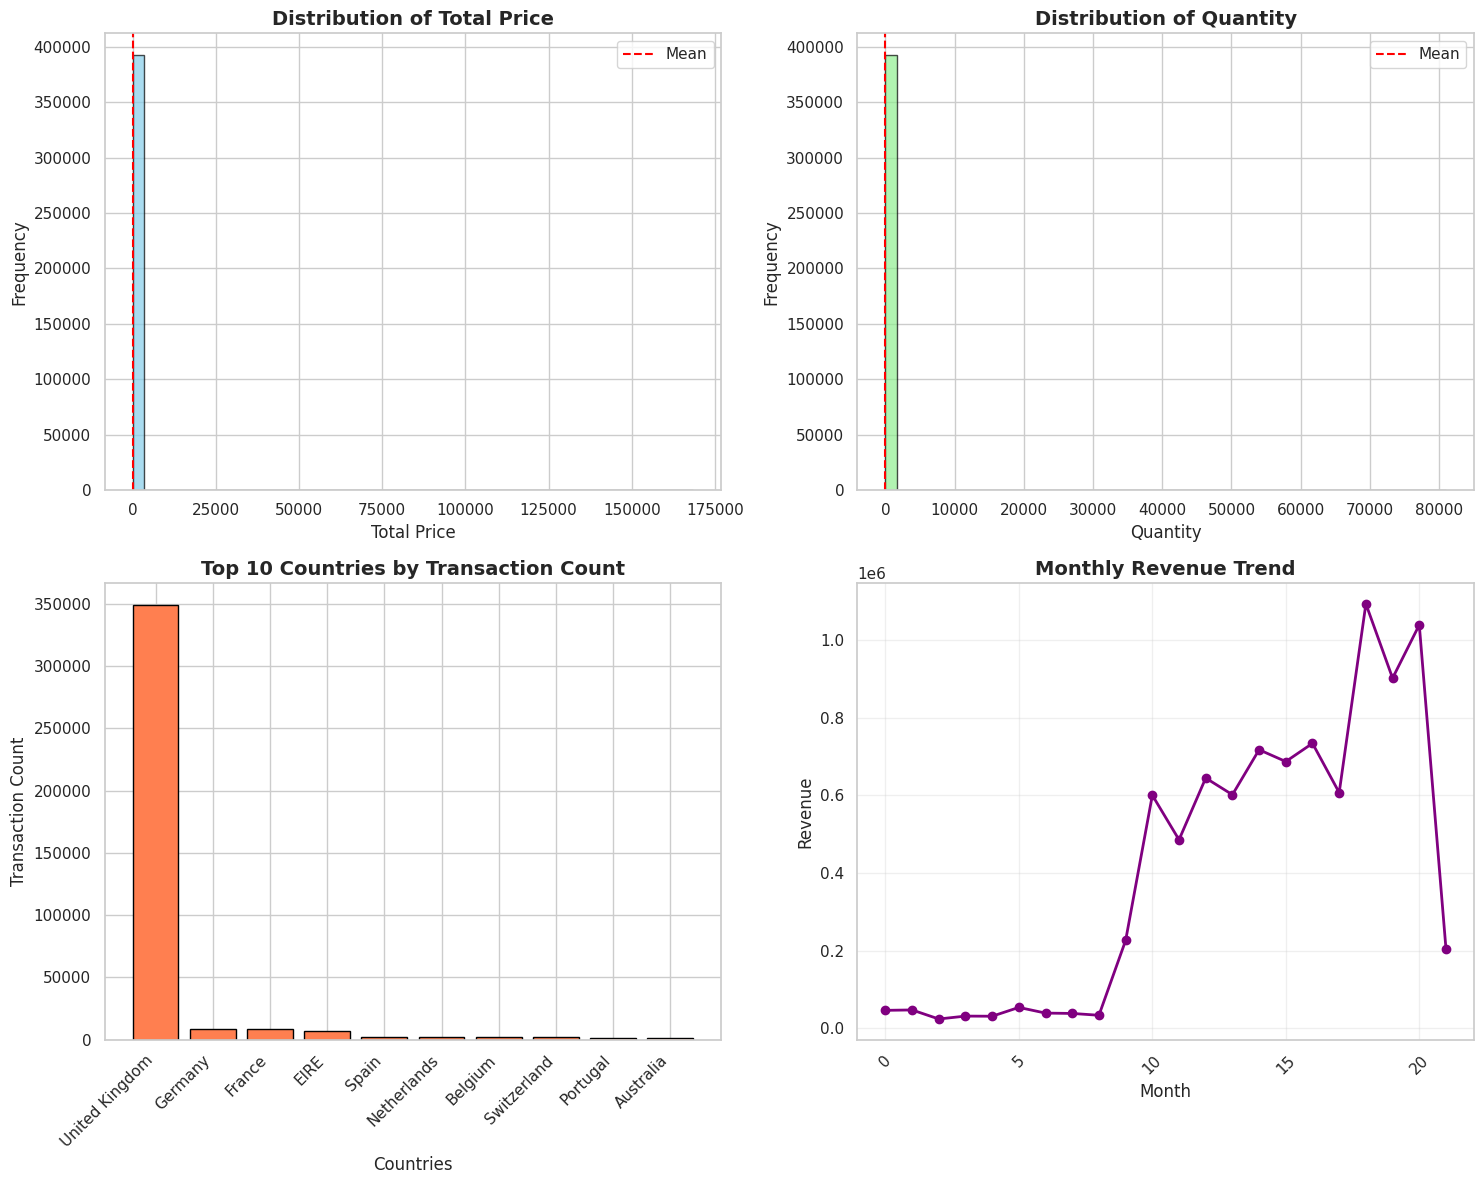

Dataset Statistics:
Total Revenue: $8,887,208.89
Average Order Value: $22.63
Total Transactions: 392,692
Unique Customers: 4,338
Unique Products: 3,665


In [ ]:
# Overview Dataset Setelah Cleaning
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribution of TotalPrice
axes[0, 0].hist(df_clean['TotalPrice'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Total Price', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Total Price')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df_clean['TotalPrice'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

# Distribution of Quantity
axes[0, 1].hist(df_clean['Quantity'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Quantity', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Quantity')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df_clean['Quantity'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 1].legend()

# Top 10 Countries by Transaction Count
country_counts = df_clean['Country'].value_counts().head(10)
axes[1, 0].bar(range(len(country_counts)), country_counts.values, color='coral', edgecolor='black')
axes[1, 0].set_title('Top 10 Countries by Transaction Count', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Countries')
axes[1, 0].set_ylabel('Transaction Count')
axes[1, 0].set_xticks(range(len(country_counts)))
axes[1, 0].set_xticklabels(country_counts.index, rotation=45, ha='right')

# Revenue by Month
df_clean['Month'] = df_clean['InvoiceDate'].dt.to_period('M')
monthly_revenue = df_clean.groupby('Month')['TotalPrice'].sum()
axes[1, 1].plot(range(len(monthly_revenue)), monthly_revenue.values, marker='o', linewidth=2, markersize=6, color='purple')
axes[1, 1].set_title('Monthly Revenue Trend', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Revenue')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Dataset Statistics:")
print(f"Total Revenue: ${df_clean['TotalPrice'].sum():,.2f}")
print(f"Average Order Value: ${df_clean['TotalPrice'].mean():.2f}")
print(f"Total Transactions: {len(df_clean):,}")
print(f"Unique Customers: {df_clean['CustomerID'].nunique():,}")
print(f"Unique Products: {df_clean['StockCode'].nunique():,}")

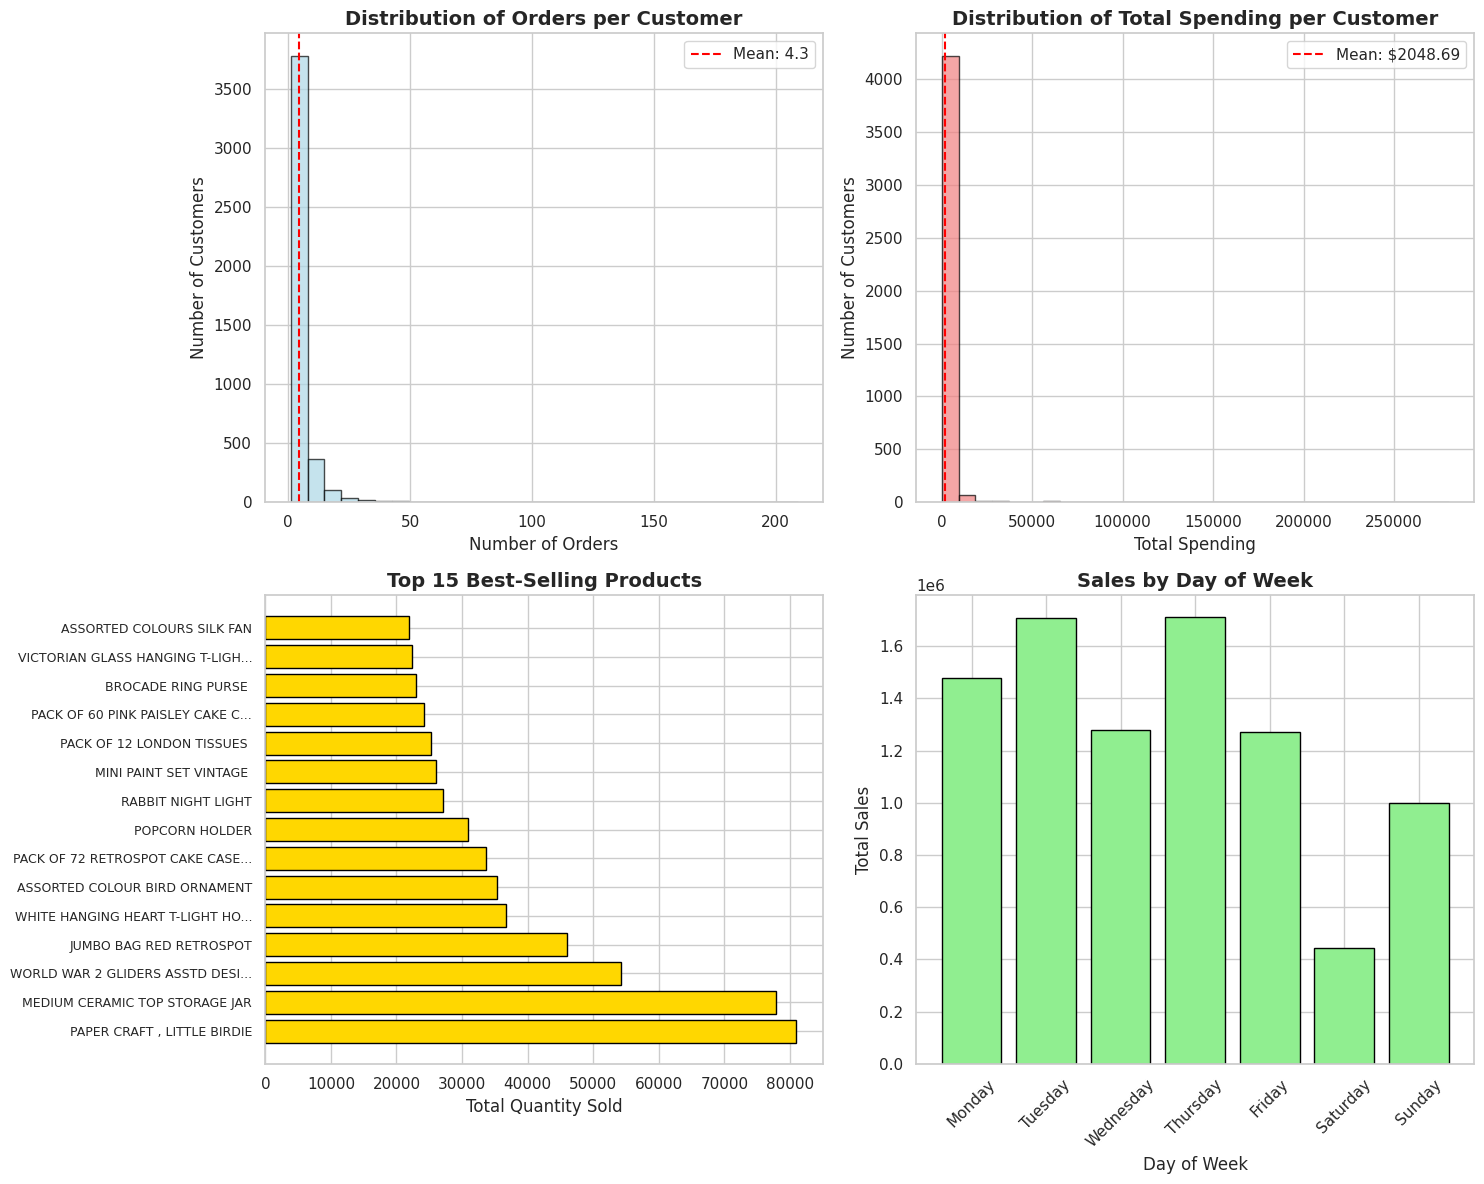

Customer Behavior Insights:
Average orders per customer: 4.3
Average spending per customer: $2048.69
Top spending customer: $280206.02
Most active day: Thursday ($1709893.44)


In [ ]:
# Customer Behavior Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Customer Frequency Distribution (Orders per Customer)
customer_orders = df_clean.groupby('CustomerID')['InvoiceNo'].nunique()
axes[0, 0].hist(customer_orders, bins=30, color='lightblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Orders per Customer', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Orders')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].axvline(customer_orders.mean(), color='red', linestyle='--', label=f'Mean: {customer_orders.mean():.1f}')
axes[0, 0].legend()

# Customer Spending Distribution
customer_spending = df_clean.groupby('CustomerID')['TotalPrice'].sum()
axes[0, 1].hist(customer_spending, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Total Spending per Customer', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Total Spending')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].axvline(customer_spending.mean(), color='red', linestyle='--', label=f'Mean: ${customer_spending.mean():.2f}')
axes[0, 1].legend()

# Top 15 Best-Selling Products
top_products = df_clean.groupby('Description')['Quantity'].sum().nlargest(15)
axes[1, 0].barh(range(len(top_products)), top_products.values, color='gold', edgecolor='black')
axes[1, 0].set_title('Top 15 Best-Selling Products', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Total Quantity Sold')
axes[1, 0].set_yticks(range(len(top_products)))
axes[1, 0].set_yticklabels([desc[:30] + '...' if len(desc) > 30 else desc for desc in top_products.index], fontsize=9)

# Daily Sales Pattern
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.day_name()
daily_sales = df_clean.groupby('DayOfWeek')['TotalPrice'].sum()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_sales = daily_sales.reindex(day_order)
axes[1, 1].bar(range(len(daily_sales)), daily_sales.values, color='lightgreen', edgecolor='black')
axes[1, 1].set_title('Sales by Day of Week', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Total Sales')
axes[1, 1].set_xticks(range(len(daily_sales)))
axes[1, 1].set_xticklabels(daily_sales.index, rotation=45)

plt.tight_layout()
plt.show()

print("Customer Behavior Insights:")
print(f"Average orders per customer: {customer_orders.mean():.1f}")
print(f"Average spending per customer: ${customer_spending.mean():.2f}")
print(f"Top spending customer: ${customer_spending.max():.2f}")
print(f"Most active day: {daily_sales.idxmax()} (${daily_sales.max():.2f})")

## Langkah 4: Spliting data (UK vs non UK)

In [ ]:
# Memisahkan data berdasarkan negara
df_uk = df_clean[df['Country'] == 'United Kingdom'].copy()
df_nonuk = df_clean[df['Country'] != 'United Kingdom'].copy()

print("Jumlah data UK    :", len(df_uk))
print("Jumlah data Non-UK:", len(df_nonuk))

# Melihat 5 data teratas UK & Non-UK
display(df_uk.head())
display(df_nonuk.head())

Jumlah data UK    : 349203
Jumlah data Non-UK: 43489


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Month,DayOfWeek
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-01,Tuesday
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-01,Tuesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-01,Tuesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-01,Tuesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-01,Tuesday


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Month,DayOfWeek
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-01-12 08:45:00,3.75,12583.0,France,90.0,2010-01,Tuesday
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-01-12 08:45:00,3.75,12583.0,France,90.0,2010-01,Tuesday
28,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-01-12 08:45:00,3.75,12583.0,France,45.0,2010-01,Tuesday
29,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-01-12 08:45:00,0.85,12583.0,France,10.2,2010-01,Tuesday
30,536370,21883,STARS GIFT TAPE,24,2010-01-12 08:45:00,0.65,12583.0,France,15.6,2010-01,Tuesday


**UK EDA**

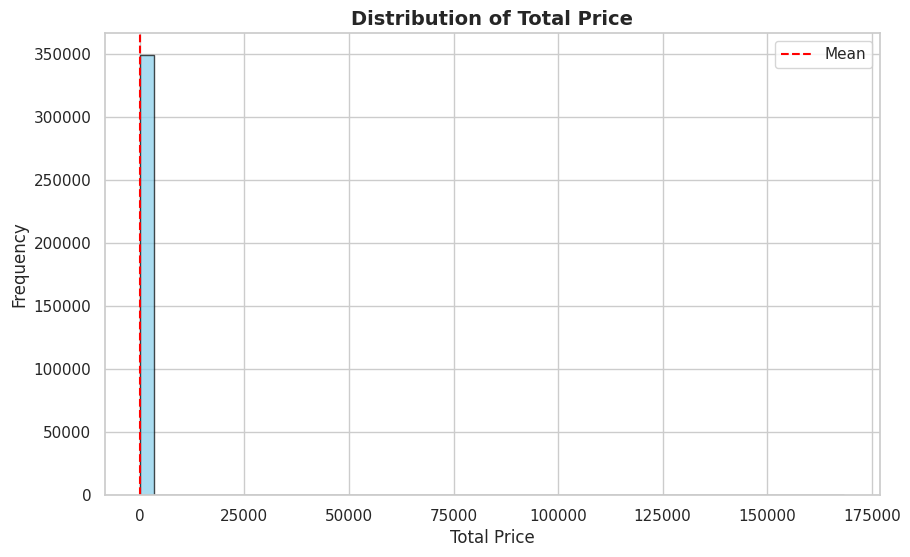

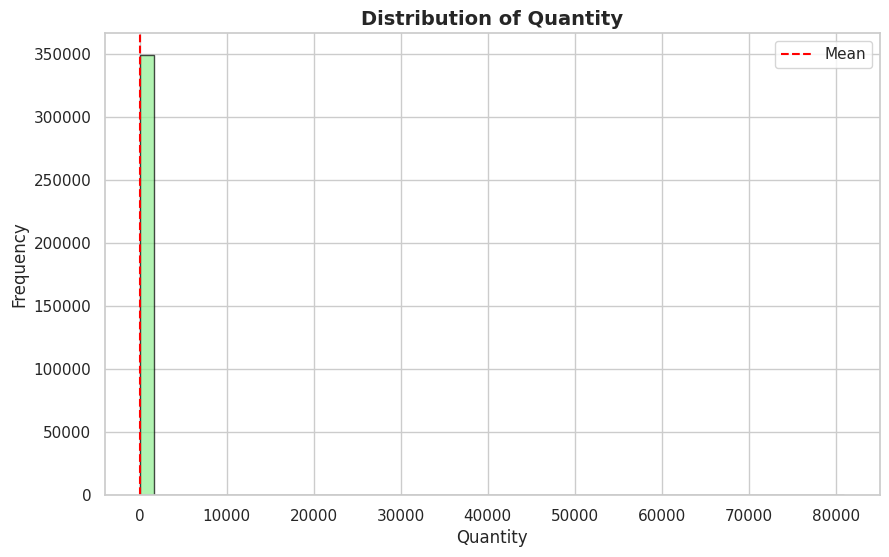

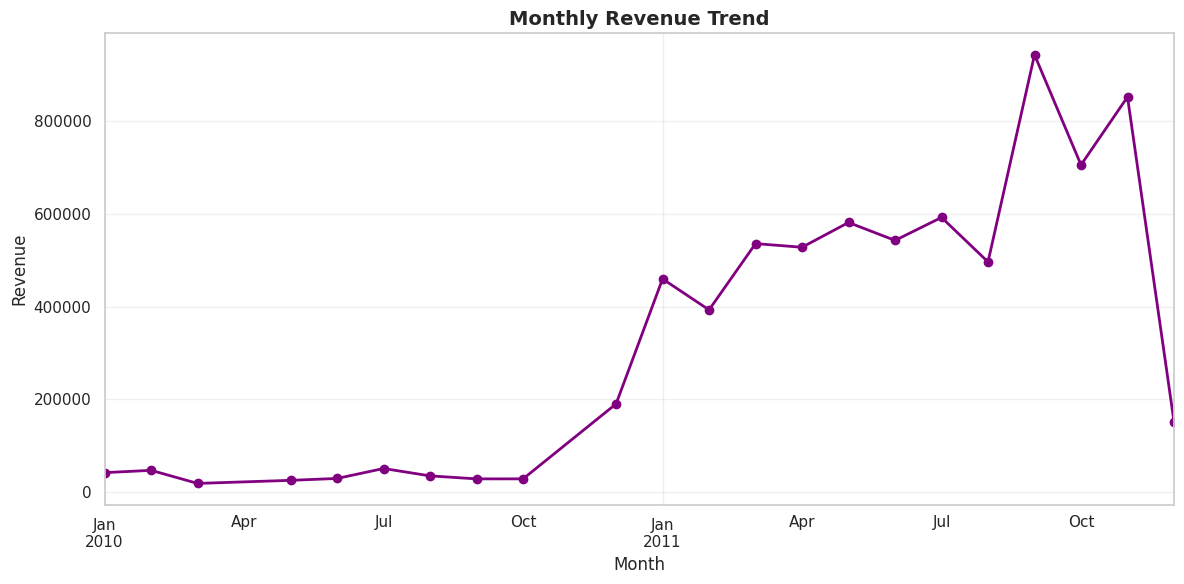

Dataset Statistics:
Total Revenue: $7,285,024.64
Average Order Value: $20.86
Total Transactions: 349,203
Unique Customers: 3,920
Unique Products: 3,645


In [ ]:
# --- Grafik 1: Distribution of TotalPrice ---
plt.figure(figsize=(10, 6))  # Mengatur ukuran per grafik
plt.hist(df_uk['TotalPrice'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Total Price', fontsize=14, fontweight='bold')
plt.xlabel('Total Price')
plt.ylabel('Frequency')
plt.axvline(df_uk['TotalPrice'].mean(), color='red', linestyle='--', label='Mean')
plt.legend()
plt.show()  # Tampilkan grafik ini saja

# --- Grafik 2: Distribution of Quantity ---
plt.figure(figsize=(10, 6))
plt.hist(df_uk['Quantity'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title('Distribution of Quantity', fontsize=14, fontweight='bold')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.axvline(df_uk['Quantity'].mean(), color='red', linestyle='--', label='Mean')
plt.legend()
plt.show()

# --- Grafik 3: Revenue by Month ---
# Persiapan Data
df_uk['Month'] = df_uk['InvoiceDate'].dt.to_period('M')
monthly_revenue = df_uk.groupby('Month')['TotalPrice'].sum()

plt.figure(figsize=(12, 6)) # Biasanya grafik tren butuh lebih lebar
# Menggunakan plot pandas bawaan agar label sumbu X (Bulan) otomatis rapi
monthly_revenue.plot(kind='line', marker='o', linewidth=2, markersize=6, color='purple')

plt.title('Monthly Revenue Trend', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Statistics Output ---
print("Dataset Statistics:")
print(f"Total Revenue: ${df_uk['TotalPrice'].sum():,.2f}")
print(f"Average Order Value: ${df_uk['TotalPrice'].mean():.2f}")
print(f"Total Transactions: {len(df_uk):,}")
print(f"Unique Customers: {df_uk['CustomerID'].nunique():,}")
print(f"Unique Products: {df_uk['StockCode'].nunique():,}")

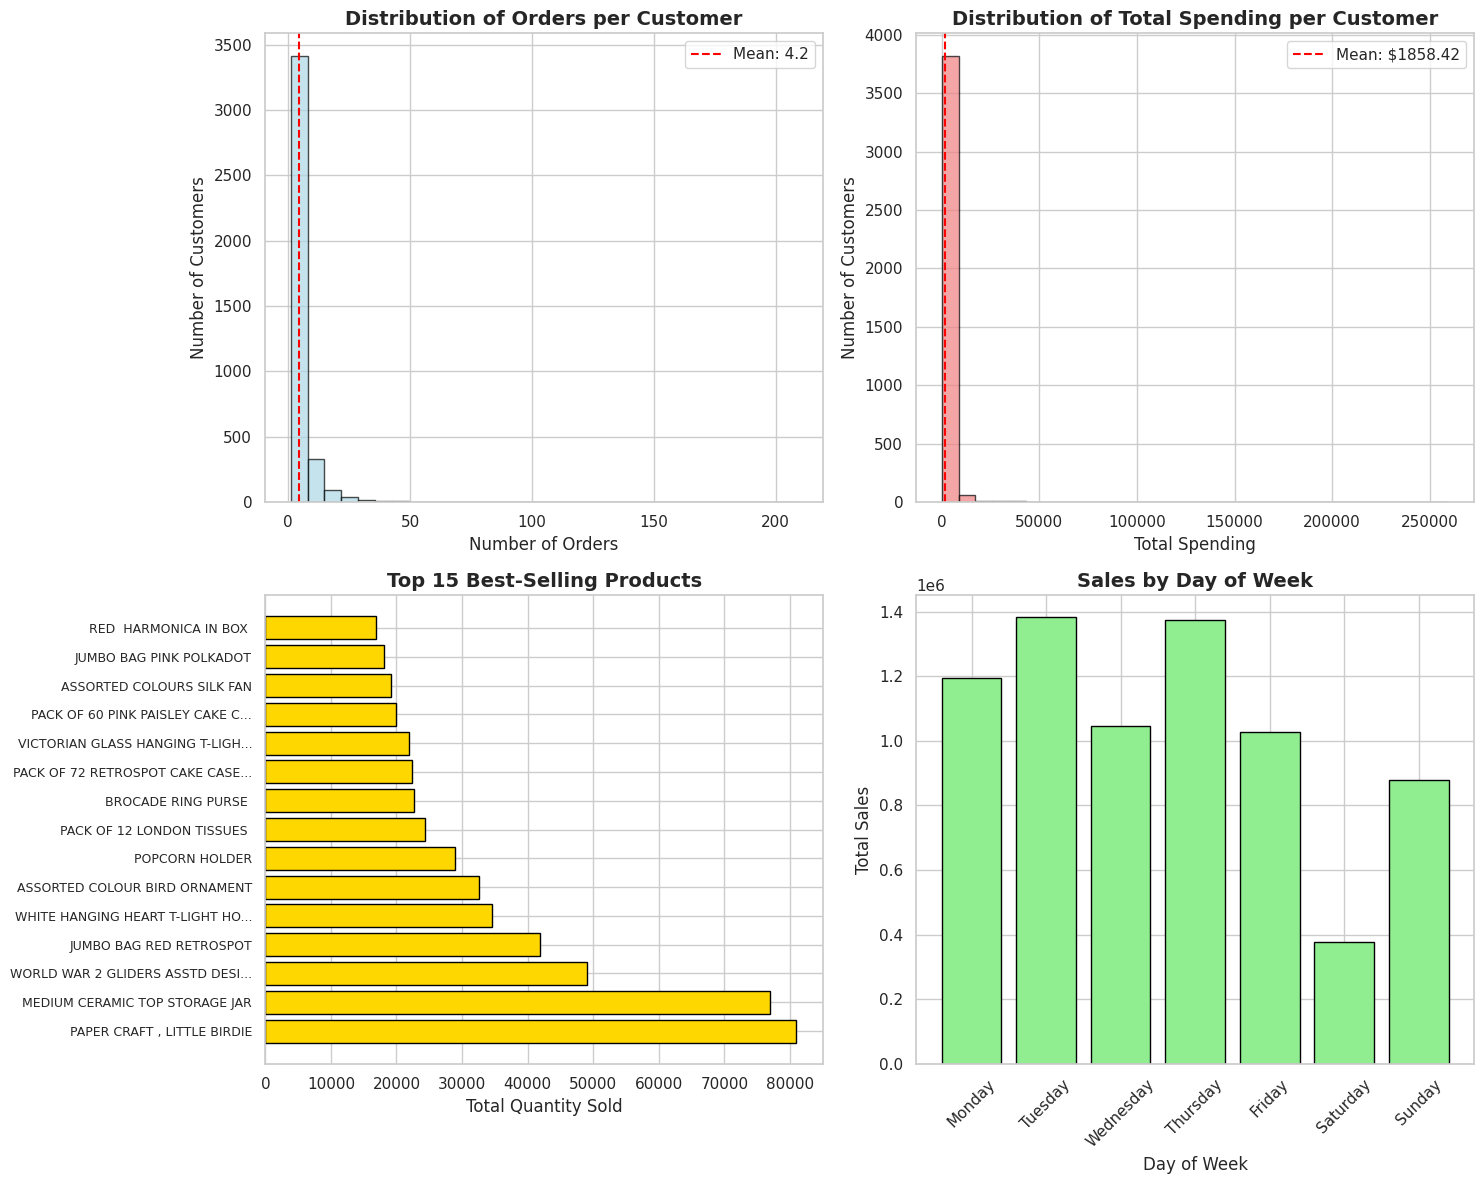

Customer Behavior Insights:
Average orders per customer: 4.2
Average spending per customer: $1858.42
Top spending customer: $259657.30
Most active day: Tuesday ($1381877.37)


In [ ]:
# Customer Behavior Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Customer Frequency Distribution (Orders per Customer)
customer_orders = df_uk.groupby('CustomerID')['InvoiceNo'].nunique()
axes[0, 0].hist(customer_orders, bins=30, color='lightblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Orders per Customer', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Orders')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].axvline(customer_orders.mean(), color='red', linestyle='--', label=f'Mean: {customer_orders.mean():.1f}')
axes[0, 0].legend()

# Customer Spending Distribution
customer_spending = df_uk.groupby('CustomerID')['TotalPrice'].sum()
axes[0, 1].hist(customer_spending, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Total Spending per Customer', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Total Spending')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].axvline(customer_spending.mean(), color='red', linestyle='--', label=f'Mean: ${customer_spending.mean():.2f}')
axes[0, 1].legend()

# Top 15 Best-Selling Products
top_products = df_uk.groupby('Description')['Quantity'].sum().nlargest(15)
axes[1, 0].barh(range(len(top_products)), top_products.values, color='gold', edgecolor='black')
axes[1, 0].set_title('Top 15 Best-Selling Products', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Total Quantity Sold')
axes[1, 0].set_yticks(range(len(top_products)))
axes[1, 0].set_yticklabels([desc[:30] + '...' if len(desc) > 30 else desc for desc in top_products.index], fontsize=9)

# Daily Sales Pattern
df_uk['DayOfWeek'] = df_uk['InvoiceDate'].dt.day_name()
daily_sales = df_uk.groupby('DayOfWeek')['TotalPrice'].sum()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_sales = daily_sales.reindex(day_order)
axes[1, 1].bar(range(len(daily_sales)), daily_sales.values, color='lightgreen', edgecolor='black')
axes[1, 1].set_title('Sales by Day of Week', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Total Sales')
axes[1, 1].set_xticks(range(len(daily_sales)))
axes[1, 1].set_xticklabels(daily_sales.index, rotation=45)

plt.tight_layout()
plt.show()

print("Customer Behavior Insights:")
print(f"Average orders per customer: {customer_orders.mean():.1f}")
print(f"Average spending per customer: ${customer_spending.mean():.2f}")
print(f"Top spending customer: ${customer_spending.max():.2f}")
print(f"Most active day: {daily_sales.idxmax()} (${daily_sales.max():.2f})")

**Non UK EDA**

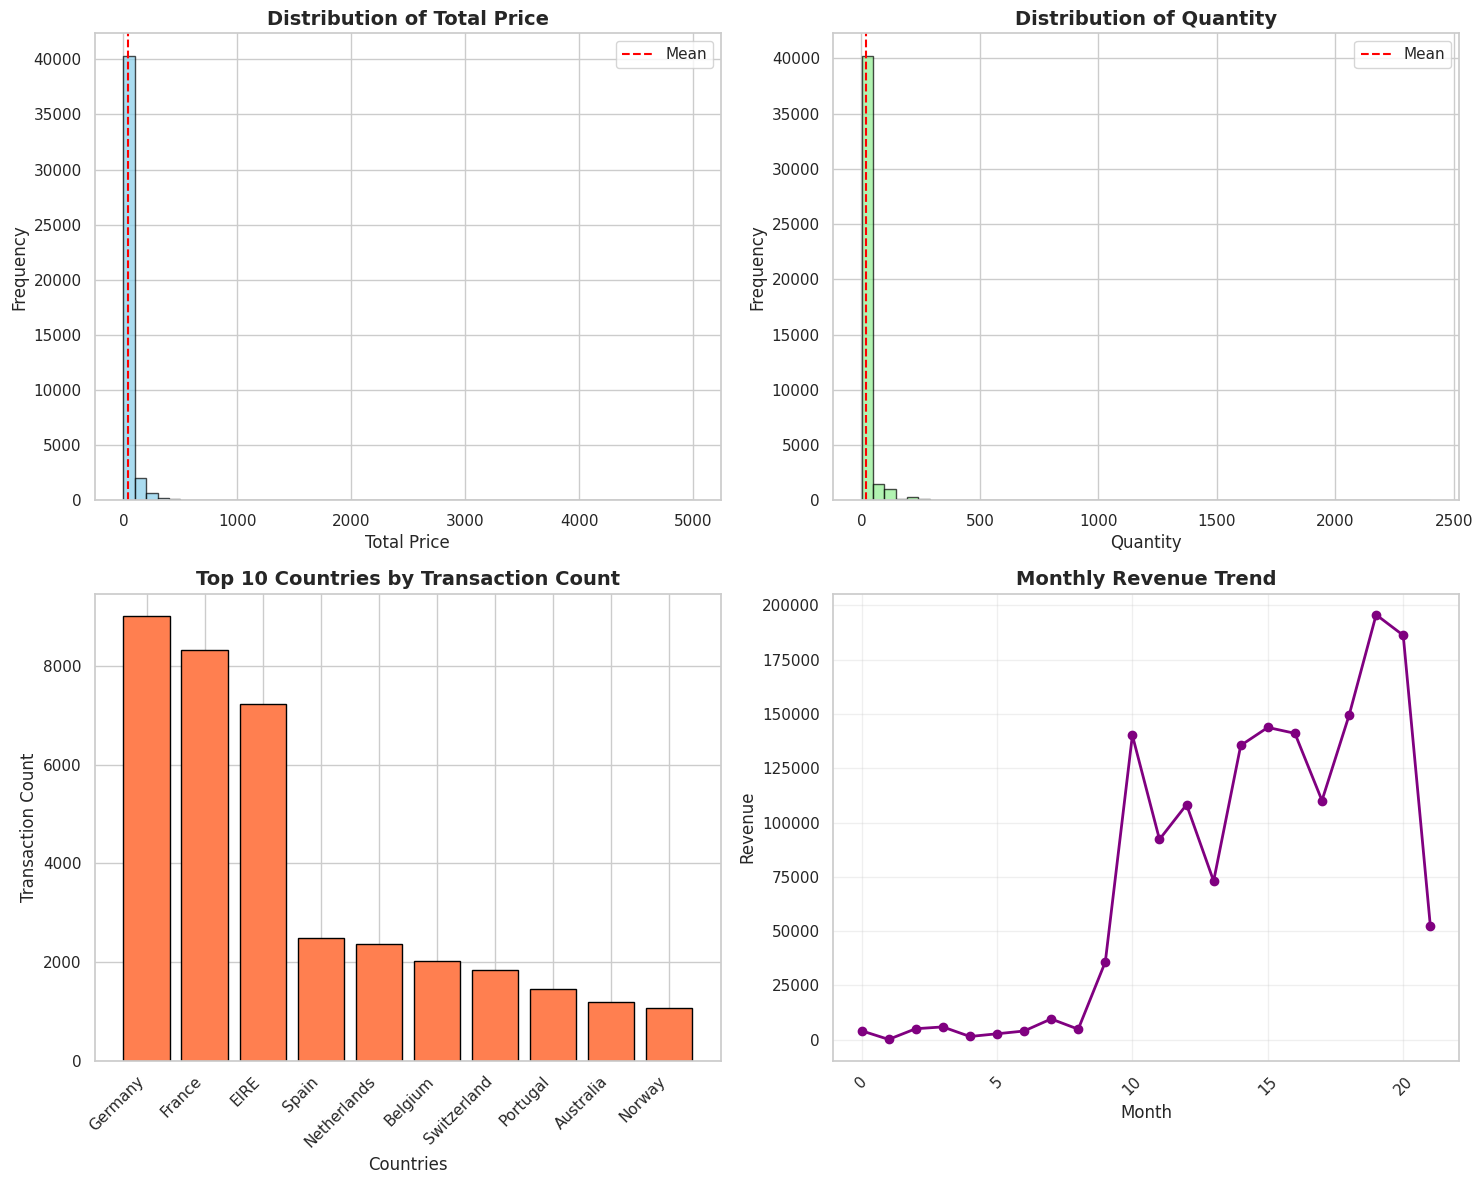

Dataset Statistics:
Total Revenue: $1,602,184.25
Average Order Value: $36.84
Total Transactions: 43,489
Unique Customers: 418
Unique Products: 2,784


In [ ]:
# 2.1.1 Overview Dataset Setelah Cleaning
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribution of TotalPrice
axes[0, 0].hist(df_nonuk['TotalPrice'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Total Price', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Total Price')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df_nonuk['TotalPrice'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

# Distribution of Quantity
axes[0, 1].hist(df_nonuk['Quantity'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Quantity', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Quantity')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df_nonuk['Quantity'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 1].legend()

# Top 10 Countries by Transaction Count
country_counts = df_nonuk['Country'].value_counts().head(10)
axes[1, 0].bar(range(len(country_counts)), country_counts.values, color='coral', edgecolor='black')
axes[1, 0].set_title('Top 10 Countries by Transaction Count', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Countries')
axes[1, 0].set_ylabel('Transaction Count')
axes[1, 0].set_xticks(range(len(country_counts)))
axes[1, 0].set_xticklabels(country_counts.index, rotation=45, ha='right')

# Revenue by Month
df_nonuk['Month'] = df_nonuk['InvoiceDate'].dt.to_period('M')
monthly_revenue = df_nonuk.groupby('Month')['TotalPrice'].sum()
axes[1, 1].plot(range(len(monthly_revenue)), monthly_revenue.values, marker='o', linewidth=2, markersize=6, color='purple')
axes[1, 1].set_title('Monthly Revenue Trend', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Revenue')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Dataset Statistics:")
print(f"Total Revenue: ${df_nonuk['TotalPrice'].sum():,.2f}")
print(f"Average Order Value: ${df_nonuk['TotalPrice'].mean():.2f}")
print(f"Total Transactions: {len(df_nonuk):,}")
print(f"Unique Customers: {df_nonuk['CustomerID'].nunique():,}")
print(f"Unique Products: {df_nonuk['StockCode'].nunique():,}")

## Langkah 5: RFM Analysis

**UK**

In [ ]:
df_uk['InvoiceDate'] = pd.to_datetime(df_uk['InvoiceDate'])
latest_date_uk = df_uk['InvoiceDate'].max()

rfm_uk = df_uk.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date_uk - x.max()).days,  # Recency
    'InvoiceNo': 'count',                                      # Frequency
    'TotalPrice': 'sum'                                        # Monetary
}).reset_index()

rfm_uk.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
display(rfm_uk.head())

# ============================
# RFM SCORING – UK
# ============================

# Recency: lower is better → score dibalik
rfm_uk['R_Score'] = pd.qcut(rfm_uk['Recency'], q=5, labels=[5,4,3,2,1])

# Frequency: higher is better → gunakan rank agar qcut tidak error
rfm_uk['F_Score'] = pd.qcut(rfm_uk['Frequency'].rank(method='first'), q=5, labels=[1,2,3,4,5])

# Monetary: higher is better
rfm_uk['M_Score'] = pd.qcut(rfm_uk['Monetary'], q=5, labels=[1,2,3,4,5])

# Convert ke integer
rfm_uk[['R_Score','F_Score','M_Score']] = rfm_uk[['R_Score','F_Score','M_Score']].astype(int)

# Membuat total RFM Score
rfm_uk['RFM_Score'] = rfm_uk['R_Score'] + rfm_uk['F_Score'] + rfm_uk['M_Score']

print("=== RFM SCORE – UK ===")
print(rfm_uk['RFM_Score'].value_counts().sort_index())
display(rfm_uk.head())

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12747.0,23,103,4196.01
2,12748.0,4,4412,33053.19
3,12749.0,23,199,4090.88
4,12820.0,45,59,942.34


=== RFM SCORE – UK ===
RFM_Score
3     217
4     232
5     346
6     336
7     367
8     334
9     327
10    317
11    301
12    305
13    293
14    282
15    263
Name: count, dtype: int64


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,326,1,77183.60,1,1,5,7
1,12747.0,23,103,4196.01,4,4,5,13
2,12748.0,4,4412,33053.19,5,5,5,15
3,12749.0,23,199,4090.88,4,5,5,14
4,12820.0,45,59,942.34,3,4,4,11


**NON-UK**

In [ ]:
df_nonuk['InvoiceDate'] = pd.to_datetime(df_nonuk['InvoiceDate'])
latest_date_nonuk = df_nonuk['InvoiceDate'].max()

rfm_nonuk = df_nonuk.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date_nonuk - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
}).reset_index()

rfm_nonuk.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
display(rfm_nonuk.head())

# ============================
# RFM SCORING – NON-UK
# ============================

# Recency
rfm_nonuk['R_Score'] = pd.qcut(rfm_nonuk['Recency'], q=5, labels=[5,4,3,2,1])

# Frequency
rfm_nonuk['F_Score'] = pd.qcut(rfm_nonuk['Frequency'].rank(method='first'), q=5, labels=[1,2,3,4,5])

# Monetary
rfm_nonuk['M_Score'] = pd.qcut(rfm_nonuk['Monetary'], q=5, labels=[1,2,3,4,5])

# Convert ke int
rfm_nonuk[['R_Score','F_Score','M_Score']] = rfm_nonuk[['R_Score','F_Score','M_Score']].astype(int)

# Total RFM Score
rfm_nonuk['RFM_Score'] = rfm_nonuk['R_Score'] + rfm_nonuk['F_Score'] + rfm_nonuk['M_Score']

print("=== RFM SCORE – NON-UK ===")
print(rfm_nonuk['RFM_Score'].value_counts().sort_index())
display(rfm_nonuk.head())

,CustomerID,Recency,Frequency,Monetary
0,12347.0,40,182,4310.00
1,12348.0,76,31,1797.24
2,12349.0,19,73,1757.55
3,12350.0,311,17,334.40
4,12352.0,73,85,2506.04


=== RFM SCORE – NON-UK ===
RFM_Score
3     30
4     27
5     33
6     33
7     37
8     26
9     35
10    38
11    36
12    37
13    30
14    24
15    32
Name: count, dtype: int64


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12347.0,40,182,4310.00,3,5,5,13
1,12348.0,76,31,1797.24,3,2,4,9
2,12349.0,19,73,1757.55,4,4,4,12
3,12350.0,311,17,334.40,1,1,1,3
4,12352.0,73,85,2506.04,3,4,4,11


## Langkah 6: RFM Segmentasi

**UK**

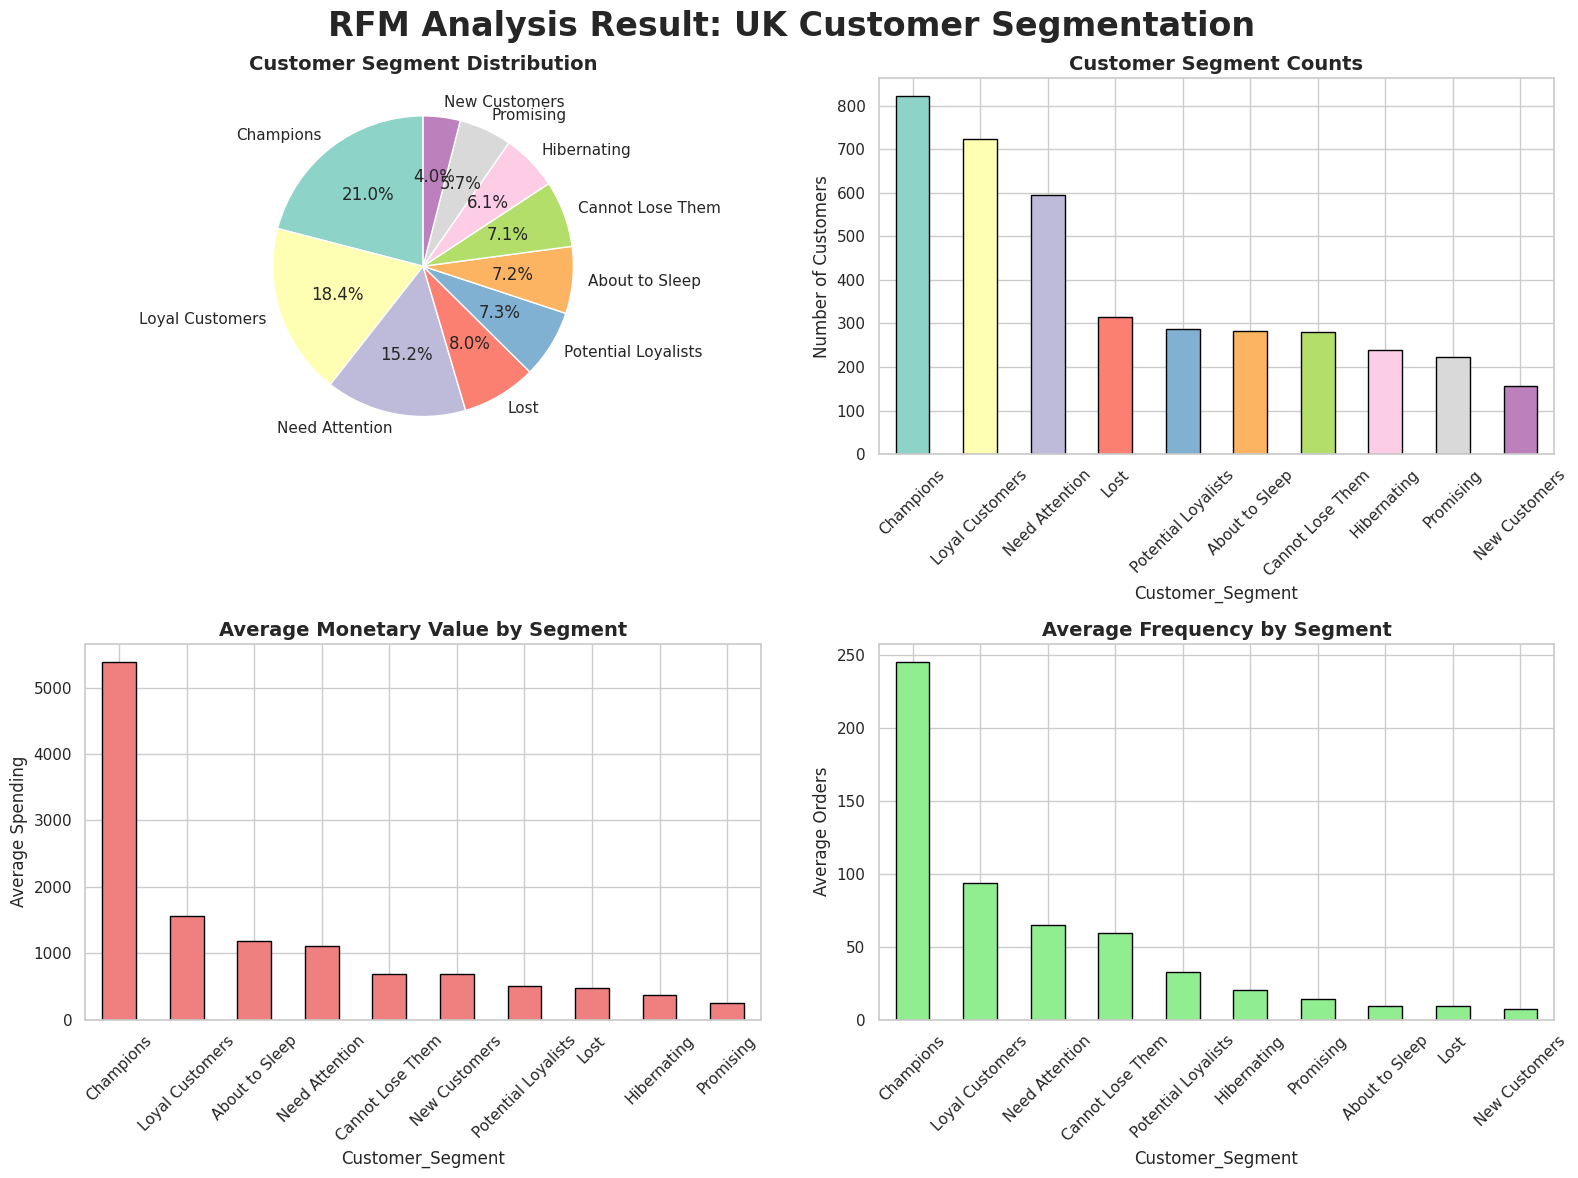

Customer Segment Summary:

Champions:
  Count: 822 (20.97%)
  Avg Monetary: $5391.70
  Avg Frequency: 245.7 orders
  Avg Recency: 16.6 days

Loyal Customers:
  Count: 723 (18.44%)
  Avg Monetary: $1555.44
  Avg Frequency: 94.0 orders
  Avg Recency: 44.1 days

Need Attention:
  Count: 594 (15.15%)
  Avg Monetary: $1102.18
  Avg Frequency: 65.1 orders
  Avg Recency: 122.7 days

Lost:
  Count: 314 (8.01%)
  Avg Monetary: $480.67
  Avg Frequency: 9.0 orders
  Avg Recency: 289.4 days

Potential Loyalists:
  Count: 288 (7.35%)
  Avg Monetary: $504.20
  Avg Frequency: 32.9 orders
  Avg Recency: 20.5 days

About to Sleep:
  Count: 282 (7.19%)
  Avg Monetary: $1180.26
  Avg Frequency: 9.3 orders
  Avg Recency: 133.4 days

Cannot Lose Them:
  Count: 280 (7.14%)
  Avg Monetary: $688.01
  Avg Frequency: 59.1 orders
  Avg Recency: 266.4 days

Hibernating:
  Count: 238 (6.07%)
  Avg Monetary: $371.33
  Avg Frequency: 20.4 orders
  Avg Recency: 289.9 days

Promising:
  Count: 223 (5.69%)
  Avg Moneta

In [ ]:
def segment_customers(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Champions'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
        return 'Loyal Customers'
    elif row['R_Score'] >= 4 and row['F_Score'] >= 2:
        return 'Potential Loyalists'
    elif row['R_Score'] >= 4 and row['F_Score'] == 1:
        return 'New Customers'
    elif row['R_Score'] >= 3 and row['F_Score'] <= 2 and row['M_Score'] <= 2:
        return 'Promising'
    elif row['R_Score'] >= 2 and row['F_Score'] >= 2 and row['M_Score'] >= 2:
        return 'Need Attention'
    elif row['R_Score'] >= 2 and row['F_Score'] <= 2:
        return 'About to Sleep'
    elif row['R_Score'] <= 2 and row['F_Score'] >= 3:
        return 'Cannot Lose Them'
    elif row['R_Score'] <= 2 and row['F_Score'] == 2:
        return 'Hibernating'
    else:
        return 'Lost'

# Apply segmentation
rfm_uk['Customer_Segment'] = rfm_uk.apply(segment_customers, axis=1)

# Segment distribution
segment_counts = rfm_uk['Customer_Segment'].value_counts()
segment_percentages = (segment_counts / len(rfm_uk) * 100).round(2)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('RFM Analysis Result: UK Customer Segmentation', fontsize=24, fontweight='bold', y=0.98)

# Segment distribution pie chart
colors = plt.cm.Set3(range(len(segment_counts)))
axes[0, 0].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%',
               colors=colors, startangle=90)
axes[0, 0].set_title('Customer Segment Distribution', fontsize=14, fontweight='bold')

# Segment distribution bar chart
segment_counts.plot(kind='bar', ax=axes[0, 1], color=colors, edgecolor='black')
axes[0, 1].set_title('Customer Segment Counts', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].tick_params(axis='x', rotation=45)

# Average Monetary by Segment
segment_monetary = rfm_uk.groupby('Customer_Segment')['Monetary'].mean().sort_values(ascending=False)
segment_monetary.plot(kind='bar', ax=axes[1, 0], color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Average Monetary Value by Segment', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Average Spending')
axes[1, 0].tick_params(axis='x', rotation=45)

# Average Frequency by Segment
segment_frequency = rfm_uk.groupby('Customer_Segment')['Frequency'].mean().sort_values(ascending=False)
segment_frequency.plot(kind='bar', ax=axes[1, 1], color='lightgreen', edgecolor='black')
axes[1, 1].set_title('Average Frequency by Segment', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Average Orders')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Customer Segment Summary:")
for segment in segment_counts.index:
    count = segment_counts[segment]
    percentage = segment_percentages[segment]
    avg_monetary = rfm_uk[rfm_uk['Customer_Segment'] == segment]['Monetary'].mean()
    avg_frequency = rfm_uk[rfm_uk['Customer_Segment'] == segment]['Frequency'].mean()
    avg_recency = rfm_uk[rfm_uk['Customer_Segment'] == segment]['Recency'].mean()

    print(f"\n{segment}:")
    print(f"  Count: {count} ({percentage}%)")
    print(f"  Avg Monetary: ${avg_monetary:.2f}")
    print(f"  Avg Frequency: {avg_frequency:.1f} orders")
    print(f"  Avg Recency: {avg_recency:.1f} days")

**Non UK**

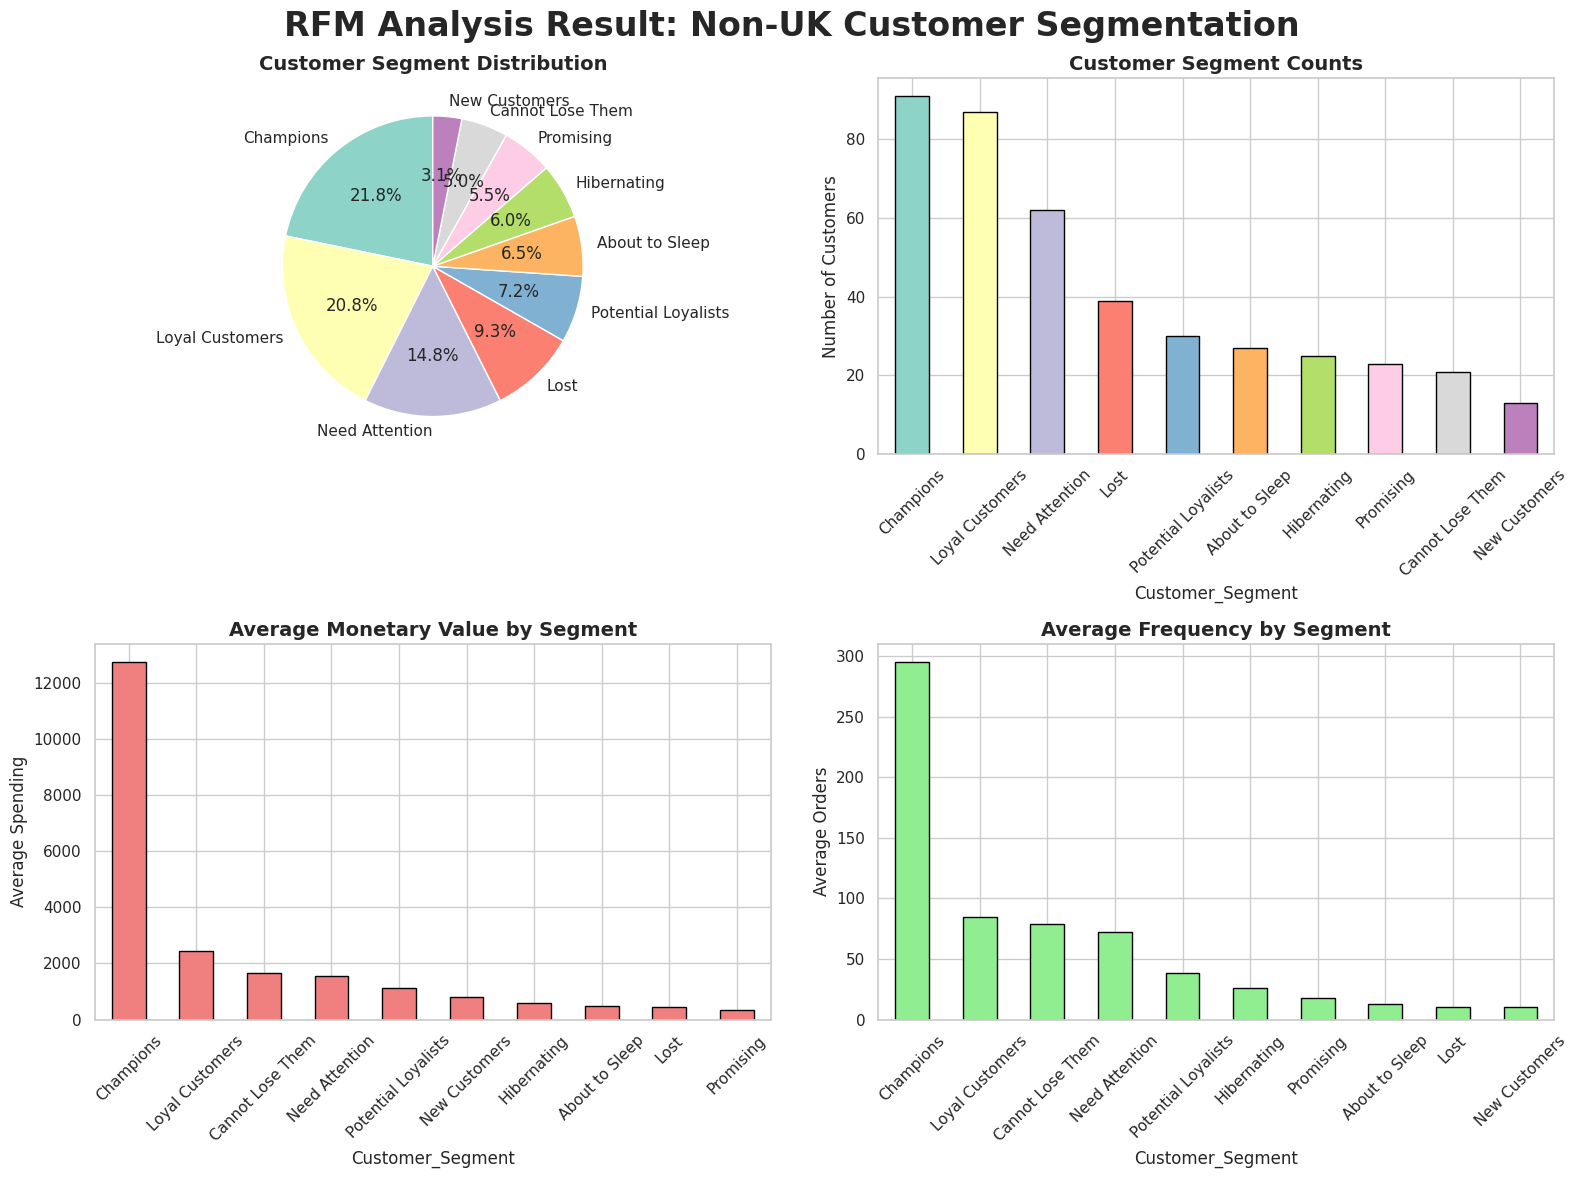

Customer Segment Summary:

Champions:
  Count: 91 (21.77%)
  Avg Monetary: $12742.90
  Avg Frequency: 295.4 orders
  Avg Recency: 15.5 days

Loyal Customers:
  Count: 87 (20.81%)
  Avg Monetary: $2454.61
  Avg Frequency: 84.8 orders
  Avg Recency: 44.4 days

Need Attention:
  Count: 62 (14.83%)
  Avg Monetary: $1563.65
  Avg Frequency: 72.0 orders
  Avg Recency: 128.6 days

Lost:
  Count: 39 (9.33%)
  Avg Monetary: $438.98
  Avg Frequency: 10.8 orders
  Avg Recency: 318.9 days

Potential Loyalists:
  Count: 30 (7.18%)
  Avg Monetary: $1131.42
  Avg Frequency: 38.3 orders
  Avg Recency: 20.5 days

About to Sleep:
  Count: 27 (6.46%)
  Avg Monetary: $468.64
  Avg Frequency: 12.5 orders
  Avg Recency: 122.7 days

Hibernating:
  Count: 25 (5.98%)
  Avg Monetary: $578.78
  Avg Frequency: 25.8 orders
  Avg Recency: 279.0 days

Promising:
  Count: 23 (5.5%)
  Avg Monetary: $357.87
  Avg Frequency: 18.1 orders
  Avg Recency: 60.6 days

Cannot Lose Them:
  Count: 21 (5.02%)
  Avg Monetary: $167

In [ ]:
def segment_customers(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Champions'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
        return 'Loyal Customers'
    elif row['R_Score'] >= 4 and row['F_Score'] >= 2:
        return 'Potential Loyalists'
    elif row['R_Score'] >= 4 and row['F_Score'] == 1:
        return 'New Customers'
    elif row['R_Score'] >= 3 and row['F_Score'] <= 2 and row['M_Score'] <= 2:
        return 'Promising'
    elif row['R_Score'] >= 2 and row['F_Score'] >= 2 and row['M_Score'] >= 2:
        return 'Need Attention'
    elif row['R_Score'] >= 2 and row['F_Score'] <= 2:
        return 'About to Sleep'
    elif row['R_Score'] <= 2 and row['F_Score'] >= 3:
        return 'Cannot Lose Them'
    elif row['R_Score'] <= 2 and row['F_Score'] == 2:
        return 'Hibernating'
    else:
        return 'Lost'

# Apply segmentation
rfm_nonuk['Customer_Segment'] = rfm_nonuk.apply(segment_customers, axis=1)

# Segment distribution
segment_counts = rfm_nonuk['Customer_Segment'].value_counts()
segment_percentages = (segment_counts / len(rfm_nonuk) * 100).round(2)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('RFM Analysis Result: Non-UK Customer Segmentation', fontsize=24, fontweight='bold', y=0.98)

# Segment distribution pie chart
colors = plt.cm.Set3(range(len(segment_counts)))
axes[0, 0].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%',
               colors=colors, startangle=90)
axes[0, 0].set_title('Customer Segment Distribution', fontsize=14, fontweight='bold')

# Segment distribution bar chart
segment_counts.plot(kind='bar', ax=axes[0, 1], color=colors, edgecolor='black')
axes[0, 1].set_title('Customer Segment Counts', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].tick_params(axis='x', rotation=45)

# Average Monetary by Segment
segment_monetary = rfm_nonuk.groupby('Customer_Segment')['Monetary'].mean().sort_values(ascending=False)
segment_monetary.plot(kind='bar', ax=axes[1, 0], color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Average Monetary Value by Segment', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Average Spending')
axes[1, 0].tick_params(axis='x', rotation=45)

# Average Frequency by Segment
segment_frequency = rfm_nonuk.groupby('Customer_Segment')['Frequency'].mean().sort_values(ascending=False)
segment_frequency.plot(kind='bar', ax=axes[1, 1], color='lightgreen', edgecolor='black')
axes[1, 1].set_title('Average Frequency by Segment', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Average Orders')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Customer Segment Summary:")
for segment in segment_counts.index:
    count = segment_counts[segment]
    percentage = segment_percentages[segment]
    avg_monetary = rfm_nonuk[rfm_nonuk['Customer_Segment'] == segment]['Monetary'].mean()
    avg_frequency = rfm_nonuk[rfm_nonuk['Customer_Segment'] == segment]['Frequency'].mean()
    avg_recency = rfm_nonuk[rfm_nonuk['Customer_Segment'] == segment]['Recency'].mean()

    print(f"\n{segment}:")
    print(f"  Count: {count} ({percentage}%)")
    print(f"  Avg Monetary: ${avg_monetary:.2f}")
    print(f"  Avg Frequency: {avg_frequency:.1f} orders")
    print(f"  Avg Recency: {avg_recency:.1f} days")

## Langkah 7: K-Means (Score Elbow)

**UK Scaled Data**

In [ ]:
# ============================
# STANDARDISASI RFM – UK
# ============================

scaler_uk = StandardScaler()
scaled_rfm_uk = scaler_uk.fit_transform(rfm_uk[['Recency', 'Frequency', 'Monetary']])

print("Scaled RFM UK (5 baris pertama):")
print(scaled_rfm_uk[:5])

Scaled RFM UK (5 baris pertama):
[[ 1.91603226 -0.41158607 10.07333861]
 [-0.71807133  0.06503332  0.31260848]
 [-0.88324614 20.19986619  4.17171859]
 [-0.71807133  0.51361628  0.2985493 ]
 [-0.52681628 -0.1405672  -0.12250925]]


**Non-UK Scaled Data**

In [ ]:
# ============================
# STANDARDISASI RFM – NON-UK
# ============================

scaler_nonuk = StandardScaler()
scaled_rfm_nonuk = scaler_nonuk.fit_transform(rfm_nonuk[['Recency', 'Frequency', 'Monetary']])

print("Scaled RFM NON-UK (5 baris pertama):")
print(scaled_rfm_nonuk[:5])

Scaled RFM NON-UK (5 baris pertama):
[[-0.55663101  0.24912263  0.02710326]
 [-0.24476179 -0.23340482 -0.11566543]
 [-0.73855472 -0.09919189 -0.11792052]
 [ 1.79105116 -0.27814247 -0.19878032]
 [-0.2707509  -0.06084534 -0.0753932 ]]


**Elbow Method (UK)**

Optimal k (Elbow) UK = 5


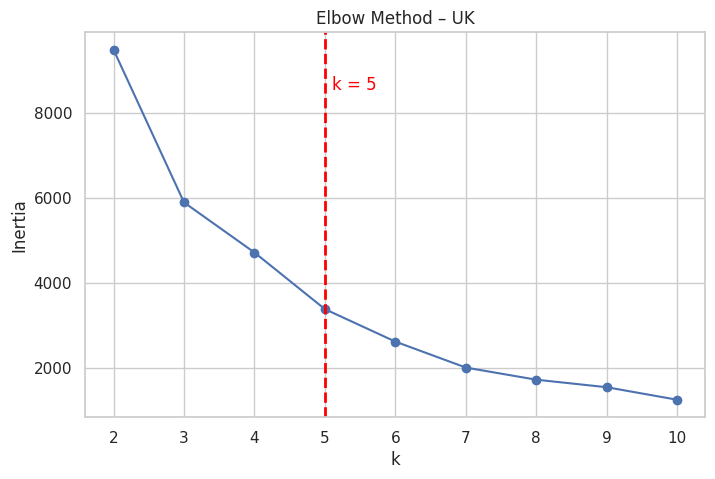


=== Silhouette Score UK ===
k=2: 0.9478
k=3: 0.5431
k=4: 0.5471
k=5: 0.5706
k=6: 0.5421
k=7: 0.5567
k=8: 0.5317
k=9: 0.5156
k=10: 0.4855


In [ ]:
# ============================
# ELBOW METHOD – UK
# ============================

inertia_uk = []
silhouette_uk = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_rfm_uk)
    inertia_uk.append(km.inertia_)

    # Hitung silhouette score (k >= 2)
    labels = km.predict(scaled_rfm_uk)
    silhouette_uk.append(silhouette_score(scaled_rfm_uk, labels))

# Cari titik elbow otomatis
kl_uk = KneeLocator(
    K, inertia_uk,
    curve="convex",
    direction="decreasing"
)

k_optimal_uk = kl_uk.elbow
print("Optimal k (Elbow) UK =", k_optimal_uk)

# Plot Elbow
plt.figure(figsize=(8,5))
plt.plot(K, inertia_uk, marker='o')
plt.title("Elbow Method – UK")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)

# Tarik garis optimal
if k_optimal_uk is not None:
    plt.axvline(x=k_optimal_uk, color='red', linestyle='--', linewidth=2)
    plt.text(k_optimal_uk+0.1, max(inertia_uk)*0.9,
             f'k = {k_optimal_uk}', color='red')

plt.show()

# Tampilkan Silhouette Score UK
print("\n=== Silhouette Score UK ===")
for k, score in zip(K, silhouette_uk):
    print(f"k={k}: {score:.4f}")

**Elbow Method (Non-UK)**

Optimal k (Elbow) NON-UK = 4


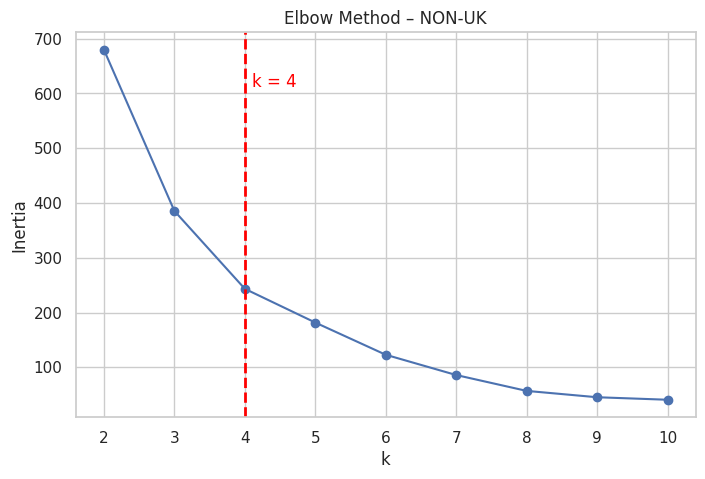


=== Silhouette Score NON-UK ===
k=2: 0.9290
k=3: 0.6107
k=4: 0.6117
k=5: 0.6134
k=6: 0.5128
k=7: 0.4674
k=8: 0.5097
k=9: 0.4595
k=10: 0.4567


In [ ]:
# ============================
# ELBOW METHOD – NON-UK
# ============================

inertia_nonuk = []
silhouette_nonuk = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_rfm_nonuk)
    inertia_nonuk.append(km.inertia_)

    # Hitung silhouette score
    labels = km.predict(scaled_rfm_nonuk)
    silhouette_nonuk.append(silhouette_score(scaled_rfm_nonuk, labels))

# Cari titik elbow otomatis
kl_nonuk = KneeLocator(
    K, inertia_nonuk,
    curve="convex",
    direction="decreasing"
)

k_optimal_nonuk = kl_nonuk.elbow
print("Optimal k (Elbow) NON-UK =", k_optimal_nonuk)

# Plot Elbow NON-UK
plt.figure(figsize=(8,5))
plt.plot(K, inertia_nonuk, marker='o')
plt.title("Elbow Method – NON-UK")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)

# Garis optimal
if k_optimal_nonuk is not None:
    plt.axvline(x=k_optimal_nonuk, color='red', linestyle='--', linewidth=2)
    plt.text(k_optimal_nonuk+0.1, max(inertia_nonuk)*0.9,
             f'k = {k_optimal_nonuk}', color='red')

plt.show()

# Tampilkan Silhouette Score NON-UK
print("\n=== Silhouette Score NON-UK ===")
for k, score in zip(K, silhouette_nonuk):
    print(f"k={k}: {score:.4f}")

**K-Means**

In [ ]:
# ============================
# K-MEANS CLUSTERING – UK (5 CLUSTER)
# ============================

kmeans_uk = KMeans(n_clusters=5, random_state=42)
rfm_uk['Cluster'] = kmeans_uk.fit_predict(scaled_rfm_uk)

print("=== Hasil Cluster UK (5 Cluster) ===")
display(rfm_uk.head())

# Melihat ringkasan tiap cluster UK
print("\n=== Statistik Setiap Cluster – UK ===")
display(rfm_uk.groupby('Cluster')[['Recency','Frequency','Monetary']].mean())

=== Hasil Cluster UK (5 Cluster) ===


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Customer_Segment,Cluster
0,12346.0,326,1,77183.60,1,1,5,7,Lost,2
1,12747.0,23,103,4196.01,4,4,5,13,Champions,1
2,12748.0,4,4412,33053.19,5,5,5,15,Champions,4
3,12749.0,23,199,4090.88,4,5,5,14,Champions,1
4,12820.0,45,59,942.34,3,4,4,11,Loyal Customers,1



=== Statistik Setiap Cluster – UK ===


,Recency,Frequency,Monetary
Cluster,,,
0,267.094527,29.930348,464.742160
1,51.928887,74.371408,1304.656501
2,23.108808,488.430052,12658.827565
3,34.666667,256.666667,207506.863333
4,4.200000,4448.400000,42289.344000


In [ ]:
# ============================
# K-MEANS CLUSTERING – NON-UK (4 CLUSTER)
# ============================

kmeans_nonuk = KMeans(n_clusters=4, random_state=42)
rfm_nonuk['Cluster'] = kmeans_nonuk.fit_predict(scaled_rfm_nonuk)

print("=== Hasil Cluster NON-UK (4 Cluster) ===")
display(rfm_nonuk.head())

# Melihat ringkasan tiap cluster Non-UK
print("\n=== Statistik Setiap Cluster – NON-UK ===")
display(rfm_nonuk.groupby('Cluster')[['Recency','Frequency','Monetary']].mean())

=== Hasil Cluster NON-UK (4 Cluster) ===


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Customer_Segment,Cluster
0,12347.0,40,182,4310.00,3,5,5,13,Loyal Customers,1
1,12348.0,76,31,1797.24,3,2,4,9,Need Attention,1
2,12349.0,19,73,1757.55,4,4,4,12,Champions,1
3,12350.0,311,17,334.40,1,1,1,3,Lost,0
4,12352.0,73,85,2506.04,3,4,4,11,Loyal Customers,1



=== Statistik Setiap Cluster – NON-UK ===


,Recency,Frequency,Monetary
Cluster,,,
0,272.048544,31.388350,790.334272
1,49.935691,97.752412,2748.353762
2,9.000000,1395.000000,174110.210000
3,0.000000,5670.000000,143711.170000


**Mapping Cluster**

=== Contoh Hasil Cluster UK dengan Nama ===


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Customer_Segment,Cluster,Cluster_Name
0,12346.0,326,1,77183.60,1,1,5,7,Lost,2,Cluster 2 – At Risk
1,12747.0,23,103,4196.01,4,4,5,13,Champions,1,Cluster 1 – Loyal Customers
2,12748.0,4,4412,33053.19,5,5,5,15,Champions,4,Cluster 4 – New / Occasional Buyers
3,12749.0,23,199,4090.88,4,5,5,14,Champions,1,Cluster 1 – Loyal Customers
4,12820.0,45,59,942.34,3,4,4,11,Loyal Customers,1,Cluster 1 – Loyal Customers


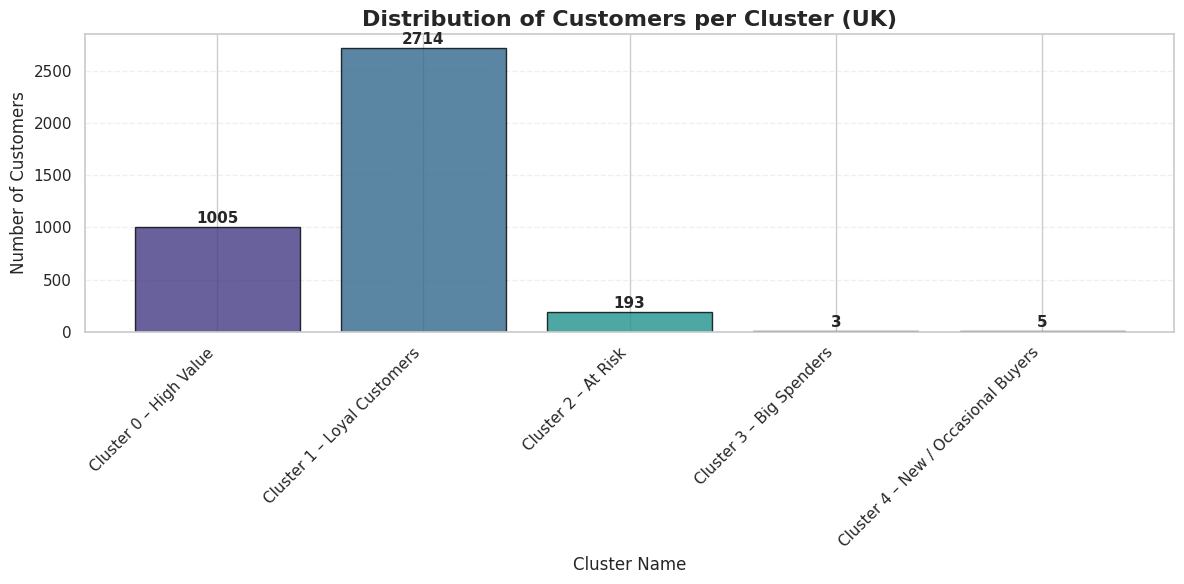

In [ ]:
# ============================
# CLUSTER NAMING – UK (5 CLUSTERS)
# ============================

cluster_names_uk = {
    0: "Cluster 0 – High Value",
    1: "Cluster 1 – Loyal Customers",
    2: "Cluster 2 – At Risk",
    3: "Cluster 3 – Big Spenders",
    4: "Cluster 4 – New / Occasional Buyers"
}

rfm_uk['Cluster_Name'] = rfm_uk['Cluster'].map(cluster_names_uk)

print("=== Contoh Hasil Cluster UK dengan Nama ===")
display(rfm_uk.head())

# Data Labels
cluster_counts = rfm_uk['Cluster_Name'].value_counts().sort_index()
plt.figure(figsize=(12, 6))

colors = sns.color_palette('viridis', n_colors=len(cluster_counts))
bars = plt.bar(cluster_counts.index, cluster_counts.values, color=colors, edgecolor='black', alpha=0.8)

# Grafik
plt.title('Distribution of Customers per Cluster (UK)', fontsize=16, fontweight='bold')
plt.xlabel('Cluster Name', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45, ha='right') # Miringkan label agar mudah dibaca
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Menambahkan Angka (Label) di atas setiap batang
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 10, # Posisi text sedikit di atas batang
             f'{int(height)}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

=== Contoh Hasil Cluster NON-UK dengan Nama ===


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Customer_Segment,Cluster,Cluster_Name
0,12347.0,40,182,4310.00,3,5,5,13,Loyal Customers,1,Cluster 1 – At Risk
1,12348.0,76,31,1797.24,3,2,4,9,Need Attention,1,Cluster 1 – At Risk
2,12349.0,19,73,1757.55,4,4,4,12,Champions,1,Cluster 1 – At Risk
3,12350.0,311,17,334.40,1,1,1,3,Lost,0,Cluster 0 – Loyal Customers
4,12352.0,73,85,2506.04,3,4,4,11,Loyal Customers,1,Cluster 1 – At Risk


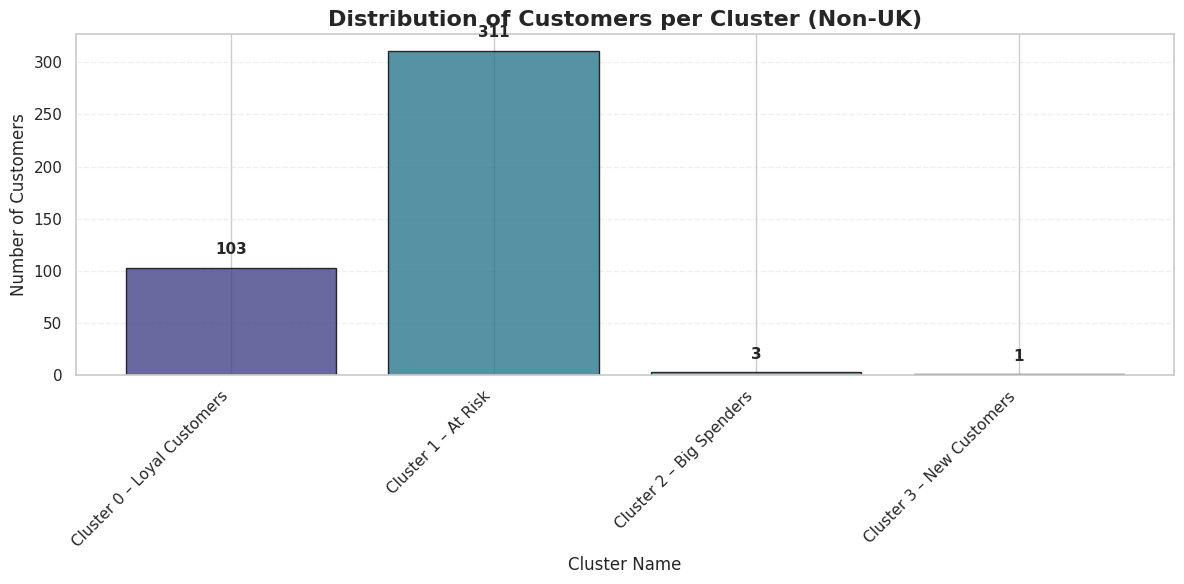

In [ ]:
# ============================
# CLUSTER NAMING – NON-UK (4 CLUSTERS)
# ============================

cluster_names_nonuk = {
    0: "Cluster 0 – Loyal Customers",
    1: "Cluster 1 – At Risk",
    2: "Cluster 2 – Big Spenders",
    3: "Cluster 3 – New Customers"
}

rfm_nonuk['Cluster_Name'] = rfm_nonuk['Cluster'].map(cluster_names_nonuk)

print("=== Contoh Hasil Cluster NON-UK dengan Nama ===")
display(rfm_nonuk.head())

# Data Labels
cluster_counts = rfm_nonuk['Cluster_Name'].value_counts().sort_index()
plt.figure(figsize=(12, 6))

colors = sns.color_palette('viridis', n_colors=len(cluster_counts))
bars = plt.bar(cluster_counts.index, cluster_counts.values, color=colors, edgecolor='black', alpha=0.8)

# Grafik
plt.title('Distribution of Customers per Cluster (Non-UK)', fontsize=16, fontweight='bold')
plt.xlabel('Cluster Name', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45, ha='right') # Miringkan label agar mudah dibaca
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Menambahkan Angka (Label) di atas setiap batang
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 10, # Posisi text sedikit di atas batang
             f'{int(height)}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Langkah 8: Visualisasi PCA 3D

**UK PCA 3D**

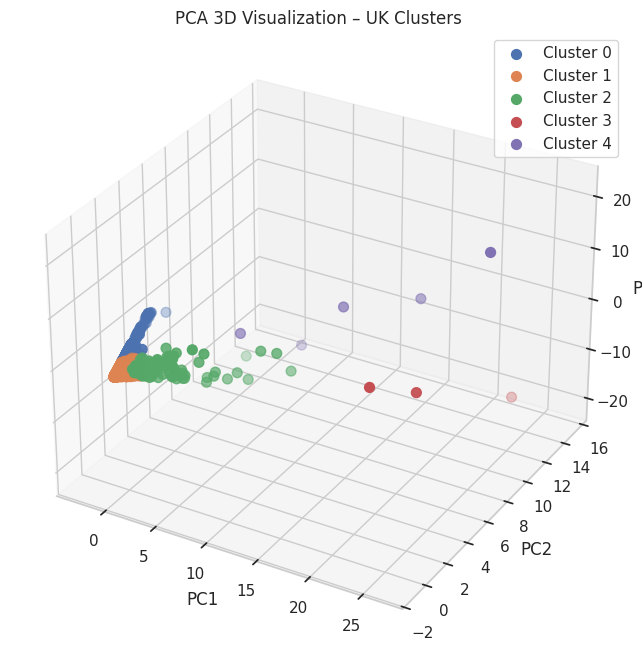

In [ ]:
# ============================
# PCA 3D UNTUK UK
# ============================
pca3_uk = PCA(n_components=3)
pca3_rfm_uk = pca3_uk.fit_transform(scaled_rfm_uk)

rfm_uk['PC1_3D'] = pca3_rfm_uk[:, 0]
rfm_uk['PC2_3D'] = pca3_rfm_uk[:, 1]
rfm_uk['PC3_3D'] = pca3_rfm_uk[:, 2]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

for cluster in cluster_names_uk:
    cluster_data = rfm_uk[rfm_uk['Cluster'] == cluster]
    ax.scatter(cluster_data['PC1_3D'], cluster_data['PC2_3D'], cluster_data['PC3_3D'],
               s=50, label=f'Cluster {cluster}')

ax.set_title("PCA 3D Visualization – UK Clusters")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()

**Non-UK PCA 3D**

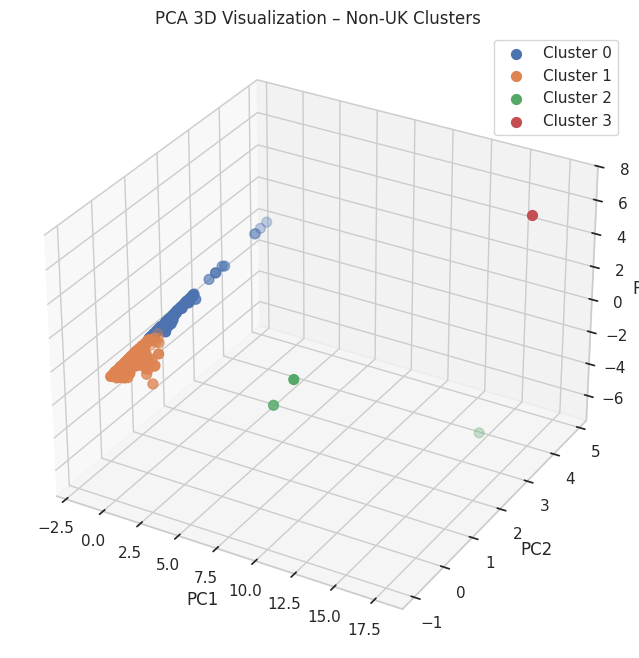

In [ ]:
# ============================
# PCA 3D UNTUK NON-UK
# ============================
pca3_nonuk = PCA(n_components=3)
pca3_rfm_nonuk = pca3_nonuk.fit_transform(scaled_rfm_nonuk)

rfm_nonuk['PC1_3D'] = pca3_rfm_nonuk[:, 0]
rfm_nonuk['PC2_3D'] = pca3_rfm_nonuk[:, 1]
rfm_nonuk['PC3_3D'] = pca3_rfm_nonuk[:, 2]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

for cluster in cluster_names_nonuk:
    cluster_data = rfm_nonuk[rfm_nonuk['Cluster'] == cluster]
    ax.scatter(cluster_data['PC1_3D'], cluster_data['PC2_3D'], cluster_data['PC3_3D'],
               s=50, label=f'Cluster {cluster}')

ax.set_title("PCA 3D Visualization – Non-UK Clusters")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()

## Langkah 9: Costumer Life Time

**UK**

In [ ]:
# ============================
# CLV – UK
# ============================

rfm_uk['CLV'] = rfm_uk['Monetary'] * rfm_uk['Frequency'] * 0.5

print("=== CLV UK (Top 10) ===")
display(rfm_uk[['CustomerID','Recency','Frequency','Monetary','CLV','Cluster']].head(10))

=== CLV UK (Top 10) ===


,CustomerID,Recency,Frequency,Monetary,CLV,Cluster
0,12346.0,326,1,77183.60,3.859180e+04,2
1,12747.0,23,103,4196.01,2.160945e+05,1
2,12748.0,4,4412,33053.19,7.291534e+07,4
3,12749.0,23,199,4090.88,4.070426e+05,1
4,12820.0,45,59,942.34,2.779903e+04,1
5,12821.0,96,6,92.72,2.781600e+02,1
6,12822.0,71,46,948.88,2.182424e+04,1
7,12823.0,75,5,1759.50,4.398750e+03,1
8,12824.0,30,25,397.12,4.964000e+03,1
9,12826.0,60,91,1474.72,6.709976e+04,1


=== CLV Segment UK (Top 10) ===


,CustomerID,CLV,CLV_segment
0,12346.0,3.859180e+04,High Value
1,12747.0,2.160945e+05,High Value
2,12748.0,7.291534e+07,High Value
3,12749.0,4.070426e+05,High Value
4,12820.0,2.779903e+04,Medium Value
5,12821.0,2.781600e+02,Low Value
6,12822.0,2.182424e+04,Medium Value
7,12823.0,4.398750e+03,Medium Value
8,12824.0,4.964000e+03,Medium Value
9,12826.0,6.709976e+04,High Value


=== Statistik CLV per Segmen (UK) ===


,CLV_segment,count,mean,min,max
0,Low Value,1307,"1,604.29",1.88,"4,324.32"
1,Medium Value,1306,"15,102.49","4,336.25","36,745.06"
2,High Value,1307,"1,022,649.15","36,754.58","166,528,620.84"


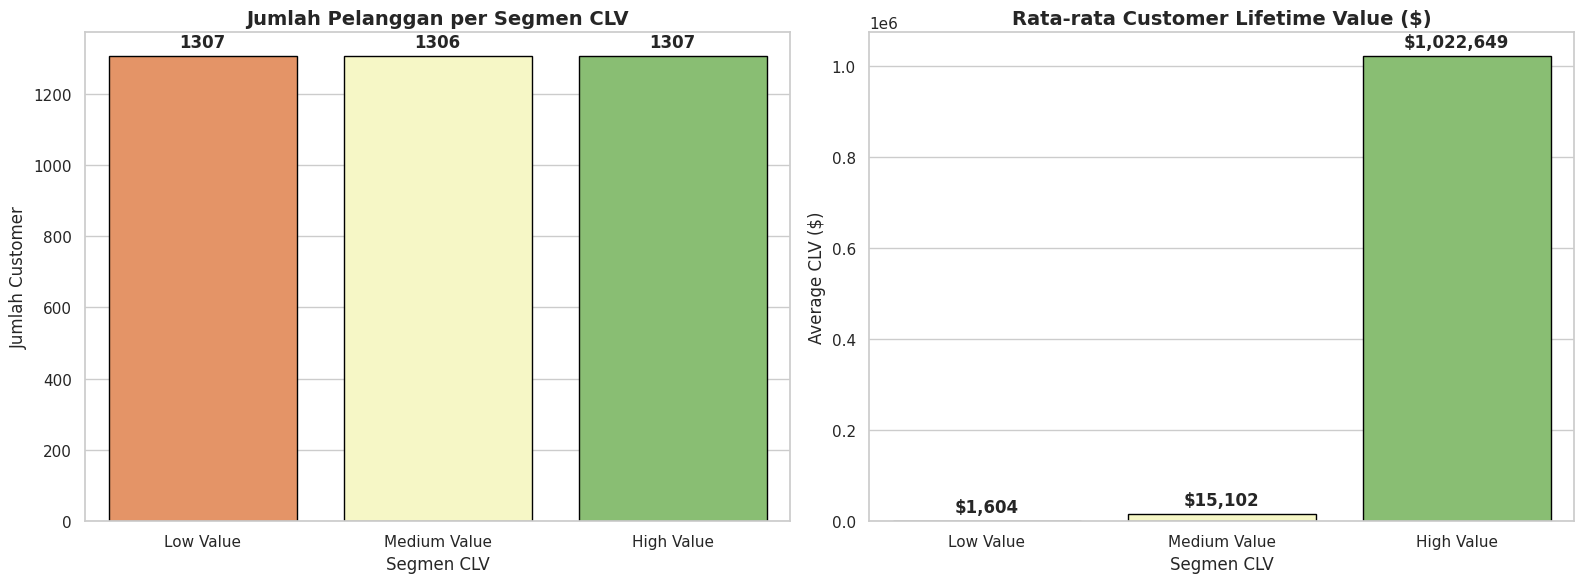

In [ ]:
# ============================
# CLV SEGMENT — UK
# ============================

rfm_uk['CLV_segment'] = pd.qcut(
    rfm_uk['CLV'],
    3,
    labels=['Low Value', 'Medium Value', 'High Value']
)

print("=== CLV Segment UK (Top 10) ===")
display(rfm_uk[['CustomerID','CLV','CLV_segment']].head(10))

# --- 1. MEMBUAT RINGKASAN STATISTIK ---
# Kita perlu melihat range nilai CLV sebenarnya di tiap segmen
clv_summary = rfm_uk.groupby('CLV_segment')['CLV'].agg(['count', 'mean', 'min', 'max']).reset_index()

print("=== Statistik CLV per Segmen (UK) ===")
display(clv_summary.style.format("{:,.2f}", subset=['mean', 'min', 'max']))

# --- 2. VISUALISASI ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Grafik A: Jumlah Customer (Seharusnya seimbang karena pakai qcut)
sns.countplot(data=rfm_uk, x='CLV_segment', palette='RdYlGn', ax=axes[0], edgecolor='black')
axes[0].set_title('Jumlah Pelanggan per Segmen CLV', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Segmen CLV')
axes[0].set_ylabel('Jumlah Customer')

# Menambahkan label angka di atas batang
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontweight='bold')

# Grafik B: Rata-rata Nilai CLV (Ini yang menunjukkan perbedaan uangnya)
sns.barplot(data=clv_summary, x='CLV_segment', y='mean', palette='RdYlGn', ax=axes[1], edgecolor='black')
axes[1].set_title('Rata-rata Customer Lifetime Value ($)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Segmen CLV')
axes[1].set_ylabel('Average CLV ($)')

# Menambahkan label nilai uang di atas batang
for p in axes[1].patches:
    axes[1].annotate(f'${p.get_height():,.0f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontweight='bold')

plt.tight_layout()
plt.show()

**Non UK**

In [ ]:
# ============================
# CLV – NON-UK
# ============================

rfm_nonuk['CLV'] = rfm_nonuk['Monetary'] * rfm_nonuk['Frequency'] * 0.5

print("=== CLV NON-UK (Top 10) ===")
display(rfm_nonuk[['CustomerID','Recency','Frequency','Monetary','CLV','Cluster']].head(10))

=== CLV NON-UK (Top 10) ===


,CustomerID,Recency,Frequency,Monetary,CLV,Cluster
0,12347.0,40,182,4310.00,392210.000,1
1,12348.0,76,31,1797.24,27857.220,1
2,12349.0,19,73,1757.55,64150.575,1
3,12350.0,311,17,334.40,2842.400,0
4,12352.0,73,85,2506.04,106506.700,1
5,12353.0,204,4,89.00,178.000,0
6,12354.0,233,58,1079.40,31302.600,0
7,12355.0,96,13,459.40,2986.100,1
8,12356.0,23,59,2811.43,82937.185,1
9,12357.0,182,131,6207.67,406602.385,0


=== CLV Segment Non-UK (Top 10) ===


,CustomerID,CLV,CLV_segment
0,12347.0,392210.000,High Value
1,12348.0,27857.220,Medium Value
2,12349.0,64150.575,Medium Value
3,12350.0,2842.400,Low Value
4,12352.0,106506.700,High Value
5,12353.0,178.000,Low Value
6,12354.0,31302.600,Medium Value
7,12355.0,2986.100,Low Value
8,12356.0,82937.185,High Value
9,12357.0,406602.385,High Value


=== Statistik CLV per Segmen (UK) ===


,CLV_segment,count,mean,min,max
0,Low Value,139,"3,287.76",94.50,"8,705.66"
1,Medium Value,139,"27,101.34","8,740.95","65,762.62"
2,High Value,140,"6,487,444.47","69,515.55","407,421,166.95"


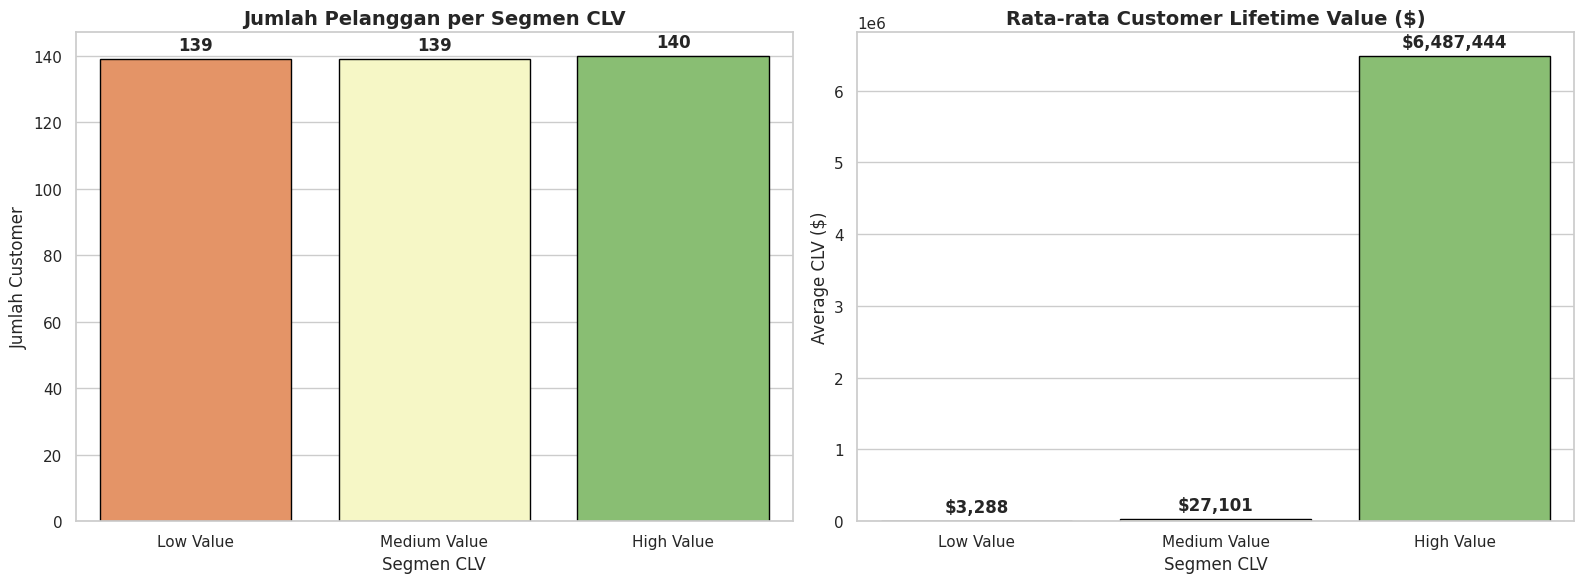

In [ ]:
# ============================
# CLV SEGMENT — NON-UK
# ============================

rfm_nonuk['CLV_segment'] = pd.qcut(
    rfm_nonuk['CLV'],
    3,
    labels=['Low Value', 'Medium Value', 'High Value']
)

print("=== CLV Segment Non-UK (Top 10) ===")
display(rfm_nonuk[['CustomerID','CLV','CLV_segment']].head(10))

# --- 1. MEMBUAT RINGKASAN STATISTIK ---
# Kita perlu melihat range nilai CLV sebenarnya di tiap segmen
clv_summary = rfm_nonuk.groupby('CLV_segment')['CLV'].agg(['count', 'mean', 'min', 'max']).reset_index()

print("=== Statistik CLV per Segmen (UK) ===")
display(clv_summary.style.format("{:,.2f}", subset=['mean', 'min', 'max']))

# --- 2. VISUALISASI ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Grafik A: Jumlah Customer (Seharusnya seimbang karena pakai qcut)
sns.countplot(data=rfm_nonuk, x='CLV_segment', palette='RdYlGn', ax=axes[0], edgecolor='black')
axes[0].set_title('Jumlah Pelanggan per Segmen CLV', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Segmen CLV')
axes[0].set_ylabel('Jumlah Customer')

# Menambahkan label angka di atas batang
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontweight='bold')

# Grafik B: Rata-rata Nilai CLV (Ini yang menunjukkan perbedaan uangnya)
sns.barplot(data=clv_summary, x='CLV_segment', y='mean', palette='RdYlGn', ax=axes[1], edgecolor='black')
axes[1].set_title('Rata-rata Customer Lifetime Value ($)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Segmen CLV')
axes[1].set_ylabel('Average CLV ($)')

# Menambahkan label nilai uang di atas batang
for p in axes[1].patches:
    axes[1].annotate(f'${p.get_height():,.0f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontweight='bold')

plt.tight_layout()
plt.show()

**🔵 High Value Customers (UK & Non-UK)**

✨ Ciri-Ciri Umum
- Frekuensi pembelian sangat tinggi
- Monetary besar → total belanja signifikan
- CLV berada di top 33% populasi
- Umumnya berasal dari cluster: Champions, Loyal Customers, atau Big Spenders
- Konsisten, repeat purchase, dan cenderung tidak sensitif harga

🇬🇧 Ciri Khusus Pelanggan UK
- Transaksi jauh lebih sering
- Nilai Monetary jauh lebih besar (karena ongkir murah & jarak dekat)
- Produk yang dibeli lebih variatif
- Banyak pelanggan performing seperti wholesaler kecil atau retail butik
- Hasil apriori menunjukkan kombinasi item lebih stabil → makanannya sering beli dengan item lain

🌍 Ciri Khusus Pelanggan Non-UK
- Nilai Monetary tetap tinggi tetapi lebih fluktuatif
- Pembelian cenderung dalam jumlah besar sekaligus, bukan sering
- Ada dampak biaya shipping internasional (belanja besar sekalian)
- Itemset lebih sedikit (pola pembelian lebih spesifik atau minimalis)

💼 Makna Bisnis
- Segmen paling penting
- 60–80% revenue biasanya berasal dari kelompok ini
- Jika hilang → potensi rugi besar
- Harus diprioritaskan dalam retensi

🎯 Strategi untuk High Value
- Loyalty rewards / membership tier
- Early access promo (pre-launch product)
- Free shipping, fast delivery, atau VIP handling
- Personalization product recommendation
- Premium packaging
- Dedicated support channel
- Bundling khusus pelanggan elite

**🟡 Medium Value Customers (UK & Non-UK)**

✨ Ciri-Ciri Umum
- Masih aktif membeli
- Belum sangat profitable tetapi berpotensi naik
- CLV berada di middle 33%
- Banyak dari cluster Potential Loyalist, Recent Customers, atau Promising

🇬🇧 Ciri Khusus Pelanggan UK
- Cenderung pembeli rutin namun tidak besar
- Monetary stabil tetapi tidak setinggi High Value
- Kemungkinan besar masih dalam tahap growth menuju loyal

🌍 Ciri Khusus Pelanggan Non-UK
- Pembelian jarang tetapi nominalnya stabil
- Banyak berasal dari negara Eropa lainnya
- Cenderung membeli produk yang sama berulang
- Pola transaksi lebih terpola (tidak banyak variasi produk)

💼 Makna Bisnis
- Kelompok yang paling ideal untuk ditingkatkan (upscaling)
- Potensial menjadi High Value dengan intervensi yang tepat
- Return on marketing investment (ROMI) sangat bagus untuk segmen ini

🎯 Strategi untuk Medium Value
- Promosi personal seperti “buy more save more”
- Cross-selling ringan (produk pelengkap)
- Upselling (versi premium dari barang yang sering dibeli)
- Voucher repeat purchase
- Edukasi produk / email newsletter
- Program membership entry-level
- Bundling harga hemat

**🔴 Low Value Customers (UK & Non-UK)**

✨ Ciri-Ciri Umum
- Pembelian sangat jarang
- Monetary kecil
- CLV bottom 33%
- Banyak berasal dari cluster Hibernating, At Risk, Lost, atau New Customer

🇬🇧 Ciri Khusus Pelanggan UK
- Banyak yang merupakan casual buyer
- Transaksi kecil & sporadis
- Cenderung membeli saat promo
- Waktu recency panjang (lama tidak belanja)

🌍 Ciri Khusus Pelanggan Non-UK
- Sering hanya membeli sekali (one-time international buyer)
- Terdampak biaya shipping luar negeri → tidak repeat
- Pola pembelian kecil tetapi beragam negara

💼 Makna Bisnis
- Segmen dengan profitabilitas rendah
- Tidak perlu effort marketing besar
- Tapi bisa diaktifkan untuk meningkatkan transaksi kecil
- Sebagian bisa diarahkan menjadi repeat buyer

🎯 Strategi untuk Low Value
- Email reminder & retargeting
- Diskon “welcome back” atau first-time buyer
- Free shipping threshold (misal: free shipping > $50)
- Rekomendasi item murah / best seller
- Flash sale atau seasonal promotions
- Edukasi nilai produk (“best seller tas ini laris karena...”)

| Segment          | CLV        | UK Characteristics                                   | Non-UK Characteristics              | Tujuan                   |
| ---------------- | ---------- | ---------------------------------------------------- | ----------------------------------- | ------------------------ |
| **High Value**   | Top 33%    | Repeat purchase tinggi, item variatif, belanja besar | Pembelian jarang tapi nominal besar | Retensi & loyalty        |
| **Medium Value** | Middle 33% | Pembelian rutin, nominal sedang                      | Pembelian jarang tapi stabil        | Upselling & engagement   |
| **Low Value**    | Bottom 33% | Casual buyer, jarang belanja                         | Banyak one-time international buyer | Aktivasi & re-engagement |


## Langkah 10: Asosiation Customer

**UK**

In [ ]:
# ============================================================
#       ASSOCIATION RULES - UK ONLY
# ============================================================

# --- 1. PRE-PROCESSING & MAPPING ---
# Mengubah StockCode jadi String untuk mencegah error
df_uk = df_uk.copy() # Gunakan copy agar tidak merusak dataframe asli
df_uk['StockCode'] = df_uk['StockCode'].astype(str)
df_uk['Description'] = df_uk['Description'].astype(str).str.strip()

# Membuat "Kamus" Barang (Agar nanti outputnya ada Namanya, bukan cuma Kode)
product_map = df_uk[['StockCode', 'Description']].dropna().drop_duplicates(subset='StockCode')
product_map = product_map.set_index('StockCode')['Description'].to_dict()

# --- 2. PERSIAPAN TRANSAKSI ---
trans_uk = (
    df_uk.groupby('InvoiceNo')['StockCode']
         .apply(list)
         .reset_index(name='Items')
)

print(f"Total Transaksi UK yang diproses: {len(trans_uk)}")

# --- 3. TRANSACTION ENCODER ---
te = TransactionEncoder()
te_uk = te.fit(trans_uk['Items']).transform(trans_uk['Items'])
df_te_uk = pd.DataFrame(te_uk, columns=te.columns_)

# --- 4. APRIORI ALGORITHM ---
# min_support=0.01 berarti barang harus muncul di minimal 1% transaksi
# Jika hasilnya kosong atau terlalu sedikit, turunkan ke 0.005
frequent_uk = apriori(df_te_uk, min_support=0.01, use_colnames=True)

print("\n=== Top 5 Frequent Itemsets ===")
display(frequent_uk.sort_values('support', ascending=False).head())

# --- 5. ASSOCIATION RULES ---
# Kita cari yang Lift > 1 (Hubungan Kuat)
rules_uk = association_rules(frequent_uk, metric="lift", min_threshold=1)

# --- 6. MENAMPILKAN NAMA BARANG (FITUR TAMBAHAN) ---
# Fungsi untuk mengubah kode produk menjadi nama barang
def get_product_names(codes):
    return ', '.join([product_map.get(code, 'Unknown') for code in codes])

# Terapkan fungsi mapping
rules_uk['Antecedents_Name'] = rules_uk['antecedents'].apply(get_product_names)
rules_uk['Consequents_Name'] = rules_uk['consequents'].apply(get_product_names)

# --- 7. HASIL AKHIR REKOMENDASI ---
# Mengambil kolom penting saja
final_cols = ['Antecedents_Name', 'Consequents_Name', 'support', 'confidence', 'lift']
top_recommendations = rules_uk.sort_values("lift", ascending=False).head(10)

print("\n=== TOP 10 REKOMENDASI PRODUK (UK) ===")
pd.set_option('display.max_colwidth', None) # Agar nama barang panjang tidak terpotong
display(top_recommendations[final_cols])

Total Transaksi UK yang diproses: 16646

=== Top 5 Frequent Itemsets ===


,support,itemsets
620,0.113601,(85123A)
617,0.086928,(85099B)
236,0.084705,(22423)
592,0.078097,(84879)
544,0.077496,(47566)



=== TOP 10 REKOMENDASI PRODUK (UK) ===


,Antecedents_Name,Consequents_Name,support,confidence,lift
507,HERB MARKER THYME,HERB MARKER ROSEMARY,0.010153,0.944134,86.829038
506,HERB MARKER ROSEMARY,HERB MARKER THYME,0.010153,0.933702,86.829038
510,REGENCY TEA PLATE GREEN,REGENCY TEA PLATE ROSES,0.011534,0.845815,52.930211
511,REGENCY TEA PLATE ROSES,REGENCY TEA PLATE GREEN,0.011534,0.721805,52.930211
482,POPPY'S PLAYHOUSE BEDROOM,POPPY'S PLAYHOUSE LIVINGROOM,0.010153,0.650000,51.769856
483,POPPY'S PLAYHOUSE LIVINGROOM,POPPY'S PLAYHOUSE BEDROOM,0.010153,0.808612,51.769856
580,SET OF 3 WOODEN STOCKING DECORATION,SET OF 3 WOODEN TREE DECORATIONS,0.010333,0.690763,50.211536
581,SET OF 3 WOODEN TREE DECORATIONS,SET OF 3 WOODEN STOCKING DECORATION,0.010333,0.751092,50.211536
487,POPPY'S PLAYHOUSE LIVINGROOM,POPPY'S PLAYHOUSE KITCHEN,0.010693,0.851675,49.225611
486,POPPY'S PLAYHOUSE KITCHEN,POPPY'S PLAYHOUSE LIVINGROOM,0.010693,0.618056,49.225611


**Non UK**

In [ ]:
# ============================================================
#       ASSOCIATION RULES - NON-UK ONLY
# ============================================================

# --- 1. PRE-PROCESSING & MAPPING ---
# Mengubah StockCode jadi String untuk mencegah error
df_nonuk = df_nonuk.copy() # Gunakan copy agar tidak merusak dataframe asli
df_nonuk['StockCode'] = df_nonuk['StockCode'].astype(str)
df_nonuk['Description'] = df_nonuk['Description'].astype(str).str.strip()

# Membuat "Kamus" Barang (Agar nanti outputnya ada Namanya, bukan cuma Kode)
product_map = df_nonuk[['StockCode', 'Description']].dropna().drop_duplicates(subset='StockCode')
product_map = product_map.set_index('StockCode')['Description'].to_dict()

# --- 2. PERSIAPAN TRANSAKSI ---
trans_nonuk = (
    df_nonuk.groupby('InvoiceNo')['StockCode']
         .apply(list)
         .reset_index(name='Items')
)

print(f"Total Transaksi UK yang diproses: {len(trans_uk)}")

# --- 3. TRANSACTION ENCODER ---
te = TransactionEncoder()
te_nonuk = te.fit(trans_nonuk['Items']).transform(trans_nonuk['Items'])
df_te_nonuk = pd.DataFrame(te_nonuk, columns=te.columns_)

# --- 4. APRIORI ALGORITHM ---
# min_support=0.01 berarti barang harus muncul di minimal 1% transaksi
# Jika hasilnya kosong atau terlalu sedikit, turunkan ke 0.005
frequent_nonuk = apriori(df_te_nonuk, min_support=0.01, use_colnames=True)

print("\n=== Top 5 Frequent Itemsets ===")
display(frequent_uk.sort_values('support', ascending=False).head())

# --- 5. ASSOCIATION RULES ---
# Kita cari yang Lift > 1 (Hubungan Kuat)
rules_nonuk = association_rules(frequent_nonuk, metric="lift", min_threshold=1)

# --- 6. MENAMPILKAN NAMA BARANG (FITUR TAMBAHAN) ---
# Fungsi untuk mengubah kode produk menjadi nama barang
def get_product_names(codes):
    return ', '.join([product_map.get(code, 'Unknown') for code in codes])

# Terapkan fungsi mapping
rules_nonuk['Antecedents_Name'] = rules_nonuk['antecedents'].apply(get_product_names)
rules_nonuk['Consequents_Name'] = rules_nonuk['consequents'].apply(get_product_names)

# --- 7. HASIL AKHIR REKOMENDASI ---
# Mengambil kolom penting saja
final_cols = ['Antecedents_Name', 'Consequents_Name', 'support', 'confidence', 'lift']
top_recommendations = rules_nonuk.sort_values("lift", ascending=False).head(10)

print("\n=== TOP 10 REKOMENDASI PRODUK (UK) ===")
pd.set_option('display.max_colwidth', None) # Agar nama barang panjang tidak terpotong
display(top_recommendations[final_cols])

Total Transaksi UK yang diproses: 16646

=== Top 5 Frequent Itemsets ===


,support,itemsets
620,0.113601,(85123A)
617,0.086928,(85099B)
236,0.084705,(22423)
592,0.078097,(84879)
544,0.077496,(47566)



=== TOP 10 REKOMENDASI PRODUK (UK) ===


,Antecedents_Name,Consequents_Name,support,confidence,lift
11950,"REGENCY TEA PLATE PINK, GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKESTAND 3 TIER","REGENCY TEA PLATE GREEN, PINK REGENCY TEACUP AND SAUCER",0.010074,0.904762,77.562771
11959,"REGENCY TEA PLATE GREEN, PINK REGENCY TEACUP AND SAUCER","REGENCY TEA PLATE PINK, GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKESTAND 3 TIER",0.010074,0.863636,77.562771
10432,"REGENCY TEA PLATE GREEN, PINK REGENCY TEACUP AND SAUCER","GREEN REGENCY TEACUP AND SAUCER, REGENCY TEA PLATE PINK",0.010604,0.909091,74.545455
10437,"GREEN REGENCY TEACUP AND SAUCER, REGENCY TEA PLATE PINK","REGENCY TEA PLATE GREEN, PINK REGENCY TEACUP AND SAUCER",0.010604,0.869565,74.545455
12521,"REGENCY TEA PLATE GREEN, PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER","GREEN REGENCY TEACUP AND SAUCER, REGENCY TEA PLATE PINK",0.010074,0.904762,74.190476
12528,"GREEN REGENCY TEACUP AND SAUCER, REGENCY TEA PLATE PINK","REGENCY TEA PLATE GREEN, PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER",0.010074,0.826087,74.190476
11951,"REGENCY TEA PLATE GREEN, PINK REGENCY TEACUP AND SAUCER, REGENCY CAKESTAND 3 TIER","GREEN REGENCY TEACUP AND SAUCER, REGENCY TEA PLATE PINK",0.010074,0.904762,74.190476
11958,"GREEN REGENCY TEACUP AND SAUCER, REGENCY TEA PLATE PINK","REGENCY TEA PLATE GREEN, PINK REGENCY TEACUP AND SAUCER, REGENCY CAKESTAND 3 TIER",0.010074,0.826087,74.190476
12517,"REGENCY TEA PLATE PINK, GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER","REGENCY TEA PLATE GREEN, PINK REGENCY TEACUP AND SAUCER",0.010074,0.863636,74.037190
12532,"REGENCY TEA PLATE GREEN, PINK REGENCY TEACUP AND SAUCER","REGENCY TEA PLATE PINK, GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER",0.010074,0.863636,74.037190


# Analisis Insight Bisnis: Segmentasi Pelanggan (UK Market)

## 1. Ringkasan Eksekutif
Berdasarkan hasil clustering menggunakan algoritma K-Means pada data transaksi ritel UK, ditemukan pola distribusi pelanggan yang sangat unik.

> **Kesimpulan Utama:**
> Perusahaan memiliki basis **retensi pelanggan yang sangat kuat**, di mana **95%** pelanggan masuk dalam kategori *Loyal* dan *High Value*. Hal ini mengindikasikan kepuasan produk (*Product-Market Fit*) yang tinggi. Namun, terdapat indikasi **stagnasi pertumbuhan (Growth Stagnation)** karena jumlah pelanggan baru (*New Buyers*) yang teridentifikasi sangat minim dalam periode data ini. Fokus strategi harus dibagi menjadi **Defensif** (mempertahankan pelanggan setia) dan **Ofensif** (meningkatkan akuisisi pelanggan baru).

---

## 2. Distribusi Pelanggan per Cluster

Berikut adalah detail jumlah pelanggan di setiap segmen yang terbentuk:

| ID Cluster | Nama Segmen | Jumlah Pelanggan | Persentase (%) | Deskripsi Singkat |
| :--- | :--- | :--- | :--- | :--- |
| **Cluster 1** | Loyal Customers | **2,714** | ~69.2% | Pelanggan setia yang sering berbelanja. |
| **Cluster 0** | High Value | **1,005** | ~25.6% | Pelanggan dengan nilai transaksi tinggi. |
| **Cluster 2** | At Risk | **193** | ~4.9% | Pelanggan yang sudah lama tidak kembali. |
| **Cluster 4** | New / Occasional | **5** | ~0.1% | Pelanggan baru atau pembeli jarang. |
| **Cluster 3** | Big Spenders | **3** | <0.1% | "Paus" dengan nilai belanja ekstrem. |

---

## 3. Analisis Mendalam & Rekomendasi Strategis

### A. The Power of Loyalty (Cluster 0 & 1)
**Observasi:**
Kedua cluster ini mendominasi populasi secara masif (Total: 3.719 pelanggan). Ini adalah tulang punggung pendapatan perusahaan.

**Insight:**
Bisnis ini sangat sehat dari sisi *retensi*. Mayoritas pelanggan cenderung melakukan *repeat order*.

**Rekomendasi Aksi:**
* **Program Referral:** Memanfaatkan basis massa yang besar ini untuk menjadi agen pemasaran (member-get-member).
* **Community Engagement:** Fokus pada pembangunan komunitas eksklusif untuk menjaga keterikatan emosional, bukan sekadar perang diskon.

### B. Critical Warning: Akuisisi Pelanggan (Cluster 4)
**Observasi:**
Cluster *New / Occasional Buyers* hanya berisi **5 orang**.

**Insight:**
Ini adalah indikator risiko jangka panjang (*Red Flag*). Rendahnya angka ini menunjukkan bahwa bisnis gagal menarik pelanggan baru (*New Acquisition*) selama periode data tersebut, atau bisnis terlalu bergantung pada pelanggan lama.

**Rekomendasi Aksi:**
* **Marketing Agresif:** Perlu alokasi budget lebih besar untuk *Brand Awareness* dan iklan yang menargetkan audiens baru.
* **Evaluasi Onboarding:** Memastikan pengalaman belanja pertama (*first purchase experience*) sangat memikat agar pelanggan baru langsung terkonversi menjadi loyal.

### C. Penanganan "Whales" (Cluster 3)
**Observasi:**
Hanya terdapat **3 orang** dalam kategori *Big Spenders*.

**Insight:**
Meskipun jumlahnya sedikit, kontribusi *revenue* kelompok ini biasanya sangat signifikan (prinsip Pareto). Kehilangan satu orang dari kelompok ini berdampak besar.

**Rekomendasi Aksi:**
* **Layanan VIP Personal:** Hindari komunikasi otomatis/bot. Gunakan *Account Manager* khusus untuk melayani kebutuhan mereka secara personal (1-on-1).

### D. Pencegahan Churn (Cluster 2)
**Observasi:**
Terdapat **193 orang** yang berisiko pergi (*At Risk*).

**Insight:**
Jumlah ini relatif kecil (hanya ~5% dari total), yang berarti tingkat kepuasan pelanggan secara umum baik. Namun, kelompok ini perlu segera ditarik kembali sebelum benar-benar hilang (*Lost*).

**Rekomendasi Aksi:**
* **Win-Back Campaign:** Mengirimkan penawaran khusus (diskon agresif atau *free shipping*) dengan pesan "We Miss You" untuk memancing transaksi kembali.

# Analisis Insight Bisnis: Segmentasi Pelanggan (Non-UK Market)

## 1. Ringkasan Eksekutif
Berbeda drastis dengan pasar domestik (UK), pasar Internasional (Non-UK) menunjukkan sinyal peringatan yang kuat.

> **Kesimpulan Utama:**
> Mayoritas pelanggan Non-UK (**74%**) masuk dalam kategori **"At Risk"**. Ini mengindikasikan bahwa setelah melakukan pembelian, pelanggan internasional cenderung tidak kembali lagi dalam waktu dekat. Hal ini kemungkinan besar disebabkan oleh **hambatan logistik** (biaya kirim mahal/waktu tunggu lama) atau siklus pembelian (*purchasing cycle*) yang memang lebih panjang dibanding pelanggan lokal. Isu **akuisisi pelanggan baru** juga sangat kritis karena hanya terdeteksi 1 pelanggan baru.

---

## 2. Distribusi Pelanggan per Cluster

Berikut adalah detail jumlah pelanggan internasional di setiap segmen:

| ID Cluster | Nama Segmen | Jumlah Pelanggan | Persentase (%) | Deskripsi Singkat |
| :--- | :--- | :--- | :--- | :--- |
| **Cluster 1** | At Risk | **311** | ~74.4% | Kelompok dominan; jarang kembali setelah beli. |
| **Cluster 0** | Loyal Customers | **103** | ~24.6% | Pelanggan internasional yang rutin belanja. |
| **Cluster 2** | Big Spenders | **3** | ~0.7% | Pembeli volume besar (kemungkinan grosir/B2B). |
| **Cluster 3** | New Customers | **1** | ~0.2% | Hampir tidak ada pertumbuhan pelanggan baru. |

---

## 3. Analisis Mendalam & Rekomendasi Strategis

### A. Dominasi "At Risk" (Masalah Retensi Global)
**Observasi:**
Sebanyak **311 pelanggan** masuk kategori berisiko pergi.

**Insight:**
Tingginya angka ini menunjukkan bahwa model bisnis saat ini mungkin kurang ramah untuk *repeat order* internasional.
* **Hipotesis:** Pelanggan mungkin merasa ongkos kirim terlalu mahal untuk belanja frekuensi tinggi, sehingga mereka hanya belanja sekali dalam jumlah banyak, lalu menghilang lama.

**Rekomendasi Aksi:**
* **Evaluasi Logistik:** Cek apakah ada opsi pengiriman yang lebih murah atau cepat.
* **Reminder Based on Cycle:** Jangan samakan frekuensi email marketing dengan UK. Kirim pengingat dalam interval yang lebih jarang namun dengan tawaran *bulk discount* (diskon grosir) untuk mengompensasi ongkos kirim.

### B. The Loyal Minority (Cluster 0)
**Observasi:**
Hanya **103 pelanggan** yang setia belanja dari luar negeri.

**Insight:**
Kelompok ini sangat unik karena mereka tetap loyal meskipun menghadapi hambatan logistik (*cross-border friction*). Mereka adalah bukti bahwa produk memiliki nilai tinggi di mata pasar global.

**Rekomendasi Aksi:**
* **Voice of Customer (VoC):** Lakukan survei pada 103 orang ini. Tanyakan: *"Kenapa Anda tetap belanja di kami walau pengiriman jauh?"*. Jawaban mereka bisa dijadikan materi promosi (testimoni) untuk menarik pelanggan internasional lain.

### C. The Invisible Growth (Cluster 3)
**Observasi:**
Hanya **1 orang** pelanggan baru (*New Customer*).

**Insight:**
Ini adalah angka yang mengkhawatirkan. Pemasaran internasional tampaknya stagnan total (*stagnant growth*). Tanpa pelanggan baru, dan dengan tingginya pelanggan *At Risk*, pasar Non-UK berisiko mati perlahan.

**Rekomendasi Aksi:**
* **Kemitraan Lokal:** Pertimbangkan bekerja sama dengan distributor lokal di negara tujuan utama (misal: Prancis atau Jerman) agar stok lebih dekat dengan pelanggan.
* **Targeted Ads:** Jalankan iklan spesifik geografis (*Geo-targeted Ads*) di negara-negara dengan basis pelanggan loyal terbanyak.

### D. Penanganan Importir Besar (Cluster 2)
**Observasi:**
Terdapat **3 Big Spenders**.

**Insight:**
Mengingat ini adalah pasar luar negeri, 3 orang ini kemungkinan besar adalah **Reseller** atau **Bisnis Kecil (B2B)** yang mengimpor barang untuk dijual kembali di negaranya.

**Rekomendasi Aksi:**
* **Program Wholesaler:** Tawarkan skema harga khusus B2B. Jika perusahaan bisa memfasilitasi mereka agar lebih mudah menjual kembali barangnya, volume pembelian mereka akan meningkat drastis.

---

## 4. Perbandingan UK vs Non-UK

| Aspek | Pasar UK (Domestik) | Pasar Non-UK (Internasional) |
| :--- | :--- | :--- |
| **Dominasi Segmen** | **Loyal & High Value (95%)** | **At Risk (74%)** |
| **Kesehatan Retensi** | Sangat Sehat | Buruk / Siklus Panjang |
| **Isu Utama** | Akuisisi Pelanggan Baru | Retensi & Logistik |
| **Fokus Strategi** | Pertahankan Loyalitas | Perbaiki Logistik & Cari Pasar Baru |